In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.model_selection import train_test_split
# from tensorflow.keras import layers, models
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import Dense
# from sklearn.impute import SimpleImputer
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam
# from sklearn.experimental import enable_iterative_imputer  # noqa
# from sklearn.impute import IterativeImputer
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
import dcor
import numpy as np
from scipy.stats import spearmanr

In [2]:
data_path = './Wimbledon_featured_matches.csv'
data = pd.read_csv(data_path)
data.head()

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,0,6.000,7.840,2,95.0,BC,NCTL,ND
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,0,5.253,7.094,1,118.0,B,CTL,ND
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,0,13.800,19.808,4,120.0,B,NCTL,D
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,0,51.108,75.631,13,130.0,BW,CTL,D
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0,0.649,0.813,1,112.0,W,NCTL,NaN


In [3]:
data.isna().sum()

match_id                 0
player1                  0
player2                  0
elapsed_time             0
set_no                   0
game_no                  0
point_no                 0
p1_sets                  0
p2_sets                  0
p1_games                 0
p2_games                 0
p1_score                 0
p2_score                 0
server                   0
serve_no                 0
point_victor             0
p1_points_won            0
p2_points_won            0
game_victor              0
set_victor               0
p1_ace                   0
p2_ace                   0
p1_winner                0
p2_winner                0
winner_shot_type         0
p1_double_fault          0
p2_double_fault          0
p1_unf_err               0
p2_unf_err               0
p1_net_pt                0
p2_net_pt                0
p1_net_pt_won            0
p2_net_pt_won            0
p1_break_pt              0
p2_break_pt              0
p1_break_pt_won          0
p2_break_pt_won          0
p

In [211]:
mapping = {'B': 0, 'BC': 1, 'BW': 2, 'C': 3, 'W': 4}
data['serve_width'] = data['serve_width'].map(mapping)
mapping = {'CTL': 1, 'NCTL': 0}
data['serve_depth'] = data['serve_depth'].map(mapping)
mapping = {'D': 1, 'ND': 0}
data['return_depth'] = data['return_depth'].map(mapping)
mapping = {'F': 1, 'B': 0, 0 : 0}
data['winner_shot_type'] = data['winner_shot_type'].map(mapping)
data['p1_score'] = data['p1_score'].replace('AD', 50)
data['p2_score'] = data['p2_score'].replace('AD', 50)

In [212]:
data['Seconds'] = pd.to_timedelta(data['elapsed_time']).dt.total_seconds()

In [213]:
data_drop = data.drop(['match_id', 'player1', 'player2', 'elapsed_time', 'winner_shot_type'], axis=1)

In [214]:
data

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,Seconds
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,6.000,7.840,2,95.0,1.0,0.0,0.0,0.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,5.253,7.094,1,118.0,0.0,1.0,0.0,38.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,13.800,19.808,4,120.0,0.0,0.0,1.0,61.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,51.108,75.631,13,130.0,2.0,1.0,1.0,91.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0.649,0.813,1,112.0,4.0,0.0,NaN,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:39:58,5,10,330,2,2,5,...,0,0,38.620,50.971,11,123.0,3.0,0.0,1.0,16798.0
7280,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:40:43,5,10,331,2,2,5,...,0,0,17.533,27.766,5,114.0,4.0,0.0,0.0,16843.0
7281,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:20,5,10,332,2,2,5,...,0,0,10.882,18.328,4,124.0,4.0,0.0,1.0,16880.0
7282,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:52,5,10,333,2,2,5,...,0,0,7.893,10.537,1,130.0,3.0,0.0,1.0,16912.0


In [215]:
data_drop

,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,p2_games,p1_score,p2_score,server,...,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,Seconds
0,1,1,1,0,0,0,0,0,0,1,...,0,0,6.000,7.840,2,95.0,1.0,0.0,0.0,0.0
1,1,1,2,0,0,0,0,0,15,1,...,0,0,5.253,7.094,1,118.0,0.0,1.0,0.0,38.0
2,1,1,3,0,0,0,0,15,15,1,...,0,0,13.800,19.808,4,120.0,0.0,0.0,1.0,61.0
3,1,1,4,0,0,0,0,15,30,1,...,0,0,51.108,75.631,13,130.0,2.0,1.0,1.0,91.0
4,1,1,5,0,0,0,0,30,30,1,...,0,0,0.649,0.813,1,112.0,4.0,0.0,NaN,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,5,10,330,2,2,5,4,0,15,1,...,0,0,38.620,50.971,11,123.0,3.0,0.0,1.0,16798.0
7280,5,10,331,2,2,5,4,15,15,1,...,0,0,17.533,27.766,5,114.0,4.0,0.0,0.0,16843.0
7281,5,10,332,2,2,5,4,30,15,1,...,0,0,10.882,18.328,4,124.0,4.0,0.0,1.0,16880.0
7282,5,10,333,2,2,5,4,30,30,1,...,0,0,7.893,10.537,1,130.0,3.0,0.0,1.0,16912.0


In [159]:
data_drop = data_drop.astype('float64')

In [216]:
rows_with_missing_values = data_drop[data_drop.isnull().any(axis=1)]
rows_without_missing_values = data_drop.dropna()

In [217]:
rows_with_missing_values

,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,p2_games,p1_score,p2_score,server,...,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,Seconds
4,1,1,5,0,0,0,0,30,30,1,...,0,0,0.649,0.813,1,112.0,4.0,0.0,NaN,141.0
16,1,2,17,0,0,1,0,40,40,2,...,0,0,5.245,5.499,1,124.0,1.0,0.0,NaN,620.0
18,1,3,19,0,0,1,1,0,0,1,...,0,0,0.899,1.073,1,126.0,3.0,1.0,NaN,684.0
25,1,4,26,0,0,2,1,0,30,2,...,0,0,0.903,1.067,1,125.0,3.0,0.0,NaN,1007.0
26,1,4,27,0,0,2,1,0,40,2,...,0,0,20.027,7.402,3,126.0,4.0,0.0,NaN,1028.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7231,5,1,282,2,2,0,0,40,40,2,...,0,0,2.138,1.318,1,126.0,3.0,0.0,NaN,14642.0
7236,5,2,287,2,2,0,1,15,30,1,...,0,0,11.511,19.837,3,118.0,3.0,1.0,NaN,14879.0
7250,5,4,301,2,2,2,1,40,0,1,...,0,0,0.851,0.676,1,123.0,3.0,1.0,NaN,15568.0
7253,5,5,304,2,2,3,1,0,30,2,...,0,0,10.781,2.412,1,124.0,3.0,0.0,NaN,15673.0


In [218]:
rows_without_missing_values

,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,p2_games,p1_score,p2_score,server,...,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,Seconds
0,1,1,1,0,0,0,0,0,0,1,...,0,0,6.000,7.840,2,95.0,1.0,0.0,0.0,0.0
1,1,1,2,0,0,0,0,0,15,1,...,0,0,5.253,7.094,1,118.0,0.0,1.0,0.0,38.0
2,1,1,3,0,0,0,0,15,15,1,...,0,0,13.800,19.808,4,120.0,0.0,0.0,1.0,61.0
3,1,1,4,0,0,0,0,15,30,1,...,0,0,51.108,75.631,13,130.0,2.0,1.0,1.0,91.0
5,1,1,6,0,0,0,0,40,30,1,...,0,0,5.291,4.249,2,97.0,2.0,0.0,0.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,5,10,330,2,2,5,4,0,15,1,...,0,0,38.620,50.971,11,123.0,3.0,0.0,1.0,16798.0
7280,5,10,331,2,2,5,4,15,15,1,...,0,0,17.533,27.766,5,114.0,4.0,0.0,0.0,16843.0
7281,5,10,332,2,2,5,4,30,15,1,...,0,0,10.882,18.328,4,124.0,4.0,0.0,1.0,16880.0
7282,5,10,333,2,2,5,4,30,30,1,...,0,0,7.893,10.537,1,130.0,3.0,0.0,1.0,16912.0


In [219]:
non_missing_columns = data_drop.columns[data_drop.notnull().all()]
non_missing_columns

Index(['set_no', 'game_no', 'point_no', 'p1_sets', 'p2_sets', 'p1_games',
       'p2_games', 'p1_score', 'p2_score', 'server', 'serve_no',
       'point_victor', 'p1_points_won', 'p2_points_won', 'game_victor',
       'set_victor', 'p1_ace', 'p2_ace', 'p1_winner', 'p2_winner',
       'p1_double_fault', 'p2_double_fault', 'p1_unf_err', 'p2_unf_err',
       'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won', 'p2_net_pt_won',
       'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won', 'p2_break_pt_won',
       'p1_break_pt_missed', 'p2_break_pt_missed', 'p1_distance_run',
       'p2_distance_run', 'rally_count', 'Seconds'],
      dtype='object')

In [220]:
missing_columns = data_drop.columns[data_drop.isnull().any()]
missing_columns

Index(['speed_mph', 'serve_width', 'serve_depth', 'return_depth'], dtype='object')

In [221]:
X = rows_without_missing_values[non_missing_columns]
X

,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,p2_games,p1_score,p2_score,server,...,p1_break_pt,p2_break_pt,p1_break_pt_won,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,Seconds
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,6.000,7.840,2,0.0
1,1,1,2,0,0,0,0,0,15,1,...,0,0,0,0,0,0,5.253,7.094,1,38.0
2,1,1,3,0,0,0,0,15,15,1,...,0,0,0,0,0,0,13.800,19.808,4,61.0
3,1,1,4,0,0,0,0,15,30,1,...,0,0,0,0,0,0,51.108,75.631,13,91.0
5,1,1,6,0,0,0,0,40,30,1,...,0,0,0,0,0,0,5.291,4.249,2,170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,5,10,330,2,2,5,4,0,15,1,...,0,0,0,0,0,0,38.620,50.971,11,16798.0
7280,5,10,331,2,2,5,4,15,15,1,...,0,0,0,0,0,0,17.533,27.766,5,16843.0
7281,5,10,332,2,2,5,4,30,15,1,...,0,0,0,0,0,0,10.882,18.328,4,16880.0
7282,5,10,333,2,2,5,4,30,30,1,...,0,0,0,0,0,0,7.893,10.537,1,16912.0


In [254]:
y = rows_without_missing_values[missing_columns]
y
y = rows_without_missing_values['speed_mph']
y
y = rows_without_missing_values['serve_width']
y
y = rows_without_missing_values['serve_depth']
y

0       0.0
1       1.0
2       0.0
3       1.0
5       0.0
       ... 
7279    0.0
7280    0.0
7281    0.0
7282    0.0
7283    0.0
Name: serve_depth, Length: 5463, dtype: float64

In [255]:
# d = X.values
# d = d.reshape(5463, 38, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.reshape(4370, 38, 3)
X_train

,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,p2_games,p1_score,p2_score,server,...,p1_break_pt,p2_break_pt,p1_break_pt_won,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,Seconds
1137,3,9,166,1,1,5,3,30,30,2,...,0,0,0,0,0,0,19.624,13.300,1,6895.0
6749,1,1,2,0,0,0,0,0,15,2,...,0,0,0,0,0,0,5.249,3.650,1,35.0
6361,4,7,183,2,1,4,2,0,0,1,...,0,0,0,0,0,0,21.364,23.472,5,7698.0
773,3,5,139,1,1,3,1,0,30,2,...,0,0,0,0,0,0,4.278,3.875,1,7090.0
2846,3,7,174,1,1,2,4,15,15,2,...,0,0,0,0,0,0,41.974,40.025,10,7307.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,1,7,40,0,0,3,3,50,40,1,...,0,0,0,0,0,0,12.991,19.215,4,1454.0
6978,1,4,29,0,0,0,3,40,40,1,...,0,0,0,0,0,0,35.456,41.723,10,1396.0
7019,2,4,70,0,1,2,1,15,0,2,...,0,0,0,0,0,0,35.028,25.613,6,3437.0
7202,4,5,253,2,1,2,2,40,50,1,...,0,1,0,1,0,0,30.007,36.614,8,13140.0


In [256]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)

# 创建IterativeImputer实例，指定MLP回归器为估计器
imputer = IterativeImputer(estimator=mlp_regressor, max_iter=10, random_state=0)

# # 对数据进行填补
# X_imputed = imputer.fit_transform(X)
mlp_regressor.fit(X_train, y_train)

MLPRegressor(max_iter=500)

In [257]:
# 使用训练好的 MLP 预测缺失值
predicted_values = mlp_regressor.predict(X_test)

# 步骤 3: 评估填补效果
mse = mean_squared_error(y_test, predicted_values)
print(f"均方误差 (MSE) 为: {mse}")

均方误差 (MSE) 为: 0.5882461865095724


In [258]:
random_forest_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
random_forest_regressor.fit(X_train, y_train)

# 进行预测
y_pred = random_forest_regressor.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
print(f"均方误差 (MSE) 为: {mse}")

test_r2_score = r2_score(y_test, y_pred)
print("Test_R2_Score:")
print(test_r2_score)

均方误差 (MSE) 为: 0.18939999999999999
Test_R2_Score:
-0.0034348030085324943


In [199]:
model = Sequential()
model.add(LSTM(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0)
_, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}')

35/35 [==============================] - 0s 4ms/step - loss: 136604928.0000 - accuracy: 0.0000e+00
Accuracy: 0.00


In [ ]:
predictions = model.predict(X_test)

In [200]:
data

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,Seconds
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,6.000,7.840,2,95.0,1.0,0.0,0.0,0.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,5.253,7.094,1,118.0,0.0,1.0,0.0,38.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,13.800,19.808,4,120.0,0.0,0.0,1.0,61.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,51.108,75.631,13,130.0,2.0,1.0,1.0,91.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0.649,0.813,1,112.0,4.0,0.0,NaN,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:39:58,5,10,330,2,2,5,...,0,0,38.620,50.971,11,123.0,3.0,0.0,1.0,16798.0
7280,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:40:43,5,10,331,2,2,5,...,0,0,17.533,27.766,5,114.0,4.0,0.0,0.0,16843.0
7281,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:20,5,10,332,2,2,5,...,0,0,10.882,18.328,4,124.0,4.0,0.0,1.0,16880.0
7282,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:52,5,10,333,2,2,5,...,0,0,7.893,10.537,1,130.0,3.0,0.0,1.0,16912.0


In [201]:
data = data.fillna(0)
data.isna().sum()

match_id              0
player1               0
player2               0
elapsed_time          0
set_no                0
game_no               0
point_no              0
p1_sets               0
p2_sets               0
p1_games              0
p2_games              0
p1_score              0
p2_score              0
server                0
serve_no              0
point_victor          0
p1_points_won         0
p2_points_won         0
game_victor           0
set_victor            0
p1_ace                0
p2_ace                0
p1_winner             0
p2_winner             0
winner_shot_type      0
p1_double_fault       0
p2_double_fault       0
p1_unf_err            0
p2_unf_err            0
p1_net_pt             0
p2_net_pt             0
p1_net_pt_won         0
p2_net_pt_won         0
p1_break_pt           0
p2_break_pt           0
p1_break_pt_won       0
p2_break_pt_won       0
p1_break_pt_missed    0
p2_break_pt_missed    0
p1_distance_run       0
p2_distance_run       0
rally_count     

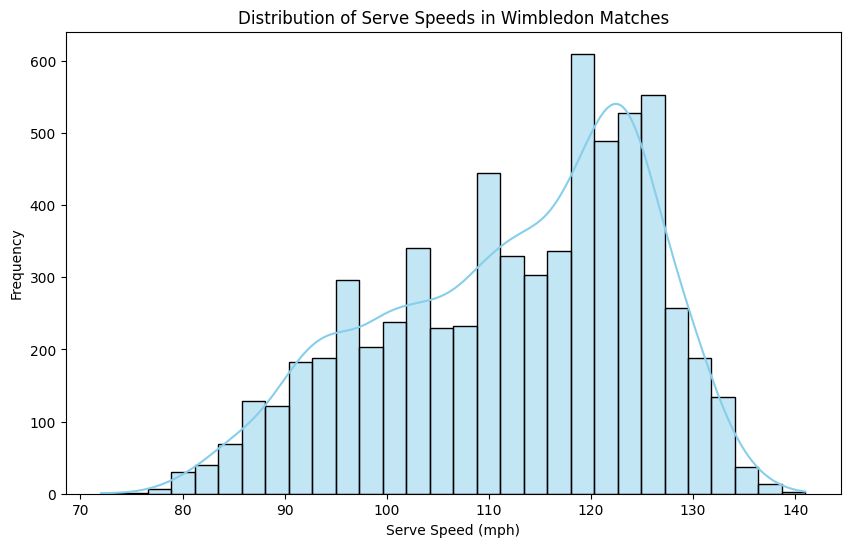

In [204]:
data_path = './Wimbledon_featured_matches.csv'
data = pd.read_csv(data_path)
plt.figure(figsize=(10, 6))
sns.histplot(data['speed_mph'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Serve Speeds in Wimbledon Matches')
plt.xlabel('Serve Speed (mph)')
plt.ylabel('Frequency')
plt.show()

C:\Users\28266\AppData\Local\Temp\ipykernel_47856\2494655218.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(player_win_counts.keys()), y=list(player_win_counts.values()), palette='coolwarm')


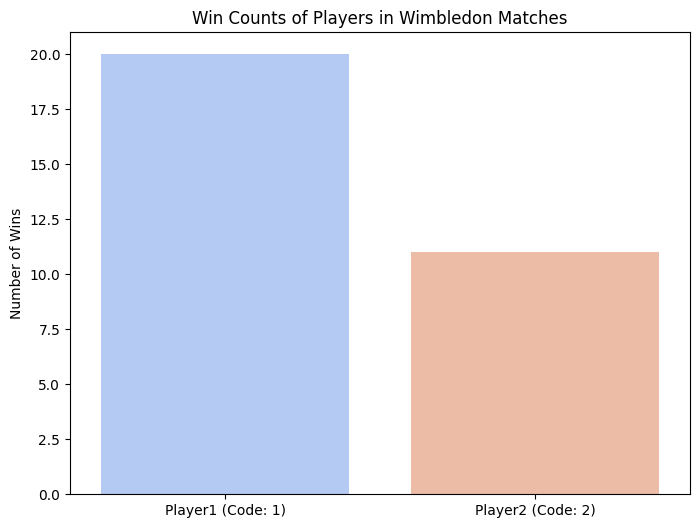

In [205]:
# 提取每场比赛的最终赢家
final_points = data.drop_duplicates(subset=['match_id'], keep='last')

# 统计每位球员胜利的次数
win_counts = final_points['game_victor'].value_counts()

player_win_counts = {'Player1 (Code: 1)': win_counts.get(1, 0), 'Player2 (Code: 2)': win_counts.get(2, 0)}

# 绘制球员胜负次数柱状图
plt.figure(figsize=(8, 6))
sns.barplot(x=list(player_win_counts.keys()), y=list(player_win_counts.values()), palette='coolwarm')
plt.title('Win Counts of Players in Wimbledon Matches')
plt.ylabel('Number of Wins')
plt.show()

In [206]:
file_path = './Wimbledon_featured_matches.csv'
data = pd.read_csv(file_path)

# 查找包含Carlos Alcaraz和Nicolas Jarry的比赛
carlos_vs_nicolas = data[((data['player1'] == 'Carlos Alcaraz') & (data['player2'] == 'Nicolas Jarry')) ]

players_data = data[(data['player1'].isin(['Carlos Alcaraz'])) | 
                    (data['player2'].isin(['Nicolas Jarry']))]

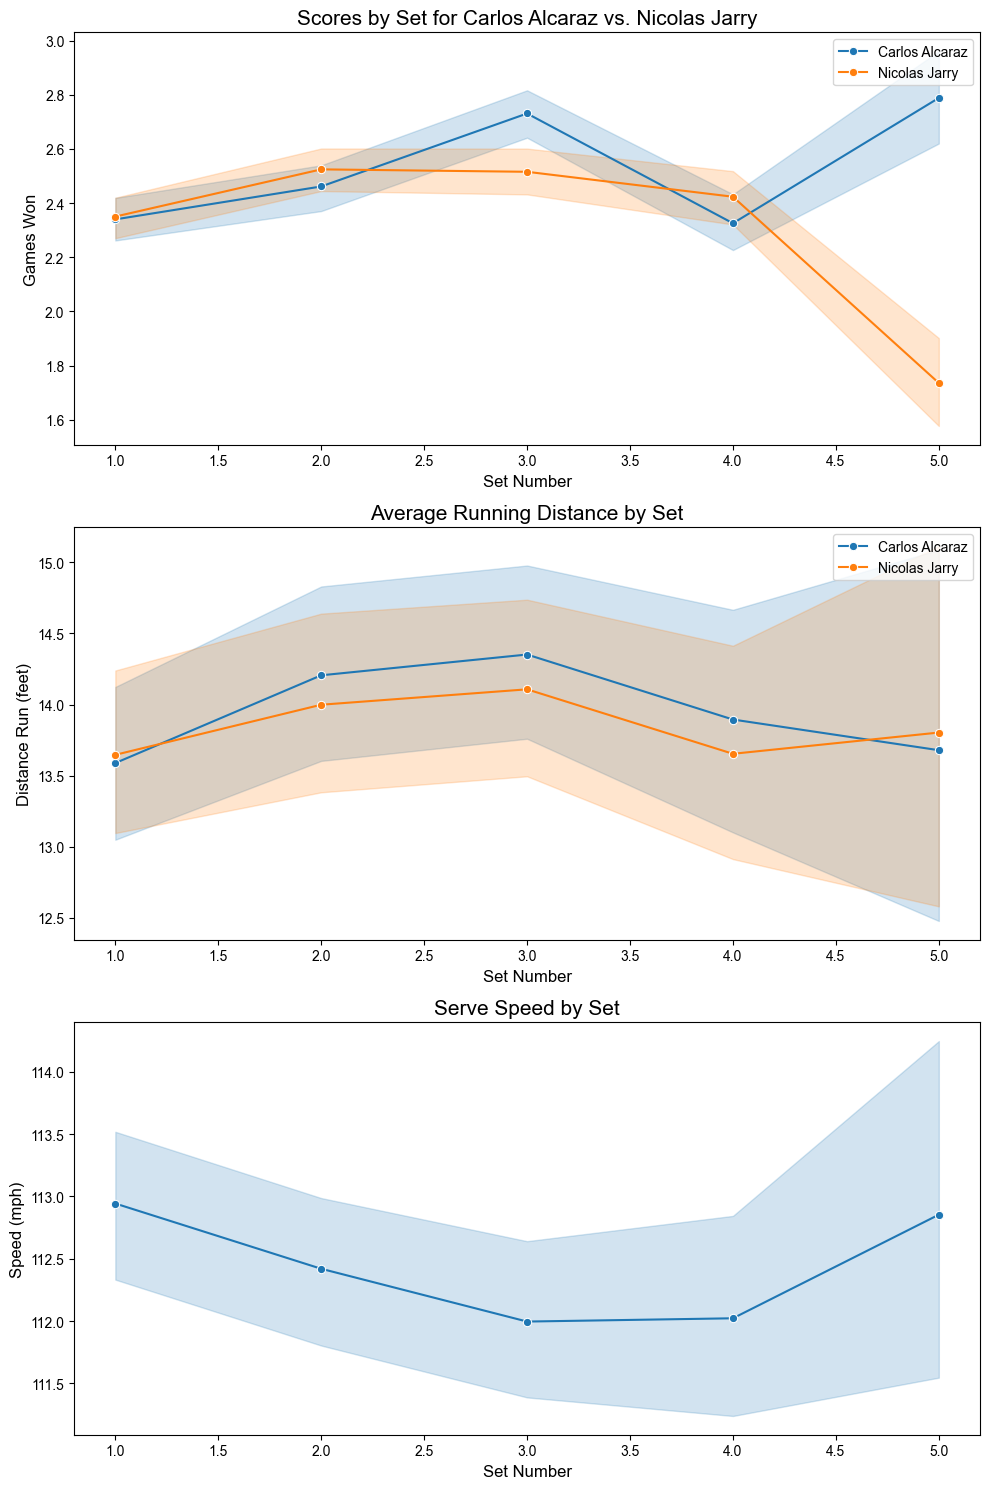

In [207]:
# 设置绘图字体
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# 绘制得分情况
sns.lineplot(x='set_no', y='p1_games', data=data, ax=axs[0], marker='o', label='Carlos Alcaraz')
sns.lineplot(x='set_no', y='p2_games', data=data, ax=axs[0], marker='o', label='Nicolas Jarry')
axs[0].set_title('Scores by Set for Carlos Alcaraz vs. Nicolas Jarry', fontsize=15)
axs[0].set_xlabel('Set Number', fontsize=12)
axs[0].set_ylabel('Games Won', fontsize=12)

# 绘制跑动距离
sns.lineplot(x='set_no', y='p1_distance_run', data=data, ax=axs[1], marker='o', label='Carlos Alcaraz')
sns.lineplot(x='set_no', y='p2_distance_run', data=data, ax=axs[1], marker='o', label='Nicolas Jarry')
axs[1].set_title('Average Running Distance by Set', fontsize=15)
axs[1].set_xlabel('Set Number', fontsize=12)
axs[1].set_ylabel('Distance Run (feet)', fontsize=12)

# 绘制发球速度
sns.lineplot(x='set_no', y='speed_mph', data=data, ax=axs[2], marker='o')
axs[2].set_title('Serve Speed by Set', fontsize=15)
axs[2].set_xlabel('Set Number', fontsize=12)
axs[2].set_ylabel('Speed (mph)', fontsize=12)

plt.tight_layout()
plt.show()

In [4]:
data = pd.read_csv('./Wimbledon_featured_matches_new.csv')
data.head()

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,serve_width,serve_depth,return_depth,speed_mph
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:00,1,1,1,0,0,0,...,0,0,0,6.000,7.840,2,1,1,1,95.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:38,1,1,2,0,0,0,...,0,0,0,5.253,7.094,1,2,2,1,118.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:01,1,1,3,0,0,0,...,0,0,0,13.800,19.808,4,2,1,2,120.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:31,1,1,4,0,0,0,...,0,0,0,51.108,75.631,13,3,2,2,130.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:02:21,1,1,5,0,0,0,...,0,0,0,0.649,0.813,1,4,1,1,112.0


In [5]:
def compute_dcor_matrix(df):
    n = df.shape[1]
    dcor_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            dcor_val = dcor.distance_correlation(df.iloc[:, i], df.iloc[:, j])
            dcor_matrix[i, j] = dcor_matrix[j, i] = dcor_val
    return dcor_matrix

In [10]:
data.iloc[:, 4:]

,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,p2_games,p1_score,p2_score,server,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,serve_width,serve_depth,return_depth,speed_mph
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,6.000,7.840,2,1,1,1,95.0
1,1,1,2,0,0,0,0,0,15,1,...,0,0,0,5.253,7.094,1,2,2,1,118.0
2,1,1,3,0,0,0,0,15,15,1,...,0,0,0,13.800,19.808,4,2,1,2,120.0
3,1,1,4,0,0,0,0,15,30,1,...,0,0,0,51.108,75.631,13,3,2,2,130.0
4,1,1,5,0,0,0,0,30,30,1,...,0,0,0,0.649,0.813,1,4,1,1,112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,5,10,330,2,2,5,4,0,15,1,...,0,0,0,38.620,50.971,11,5,1,2,123.0
7280,5,10,331,2,2,5,4,15,15,1,...,0,0,0,17.533,27.766,5,4,1,1,114.0
7281,5,10,332,2,2,5,4,30,15,1,...,0,0,0,10.882,18.328,4,4,1,2,124.0
7282,5,10,333,2,2,5,4,30,30,1,...,0,0,0,7.893,10.537,1,5,1,2,130.0


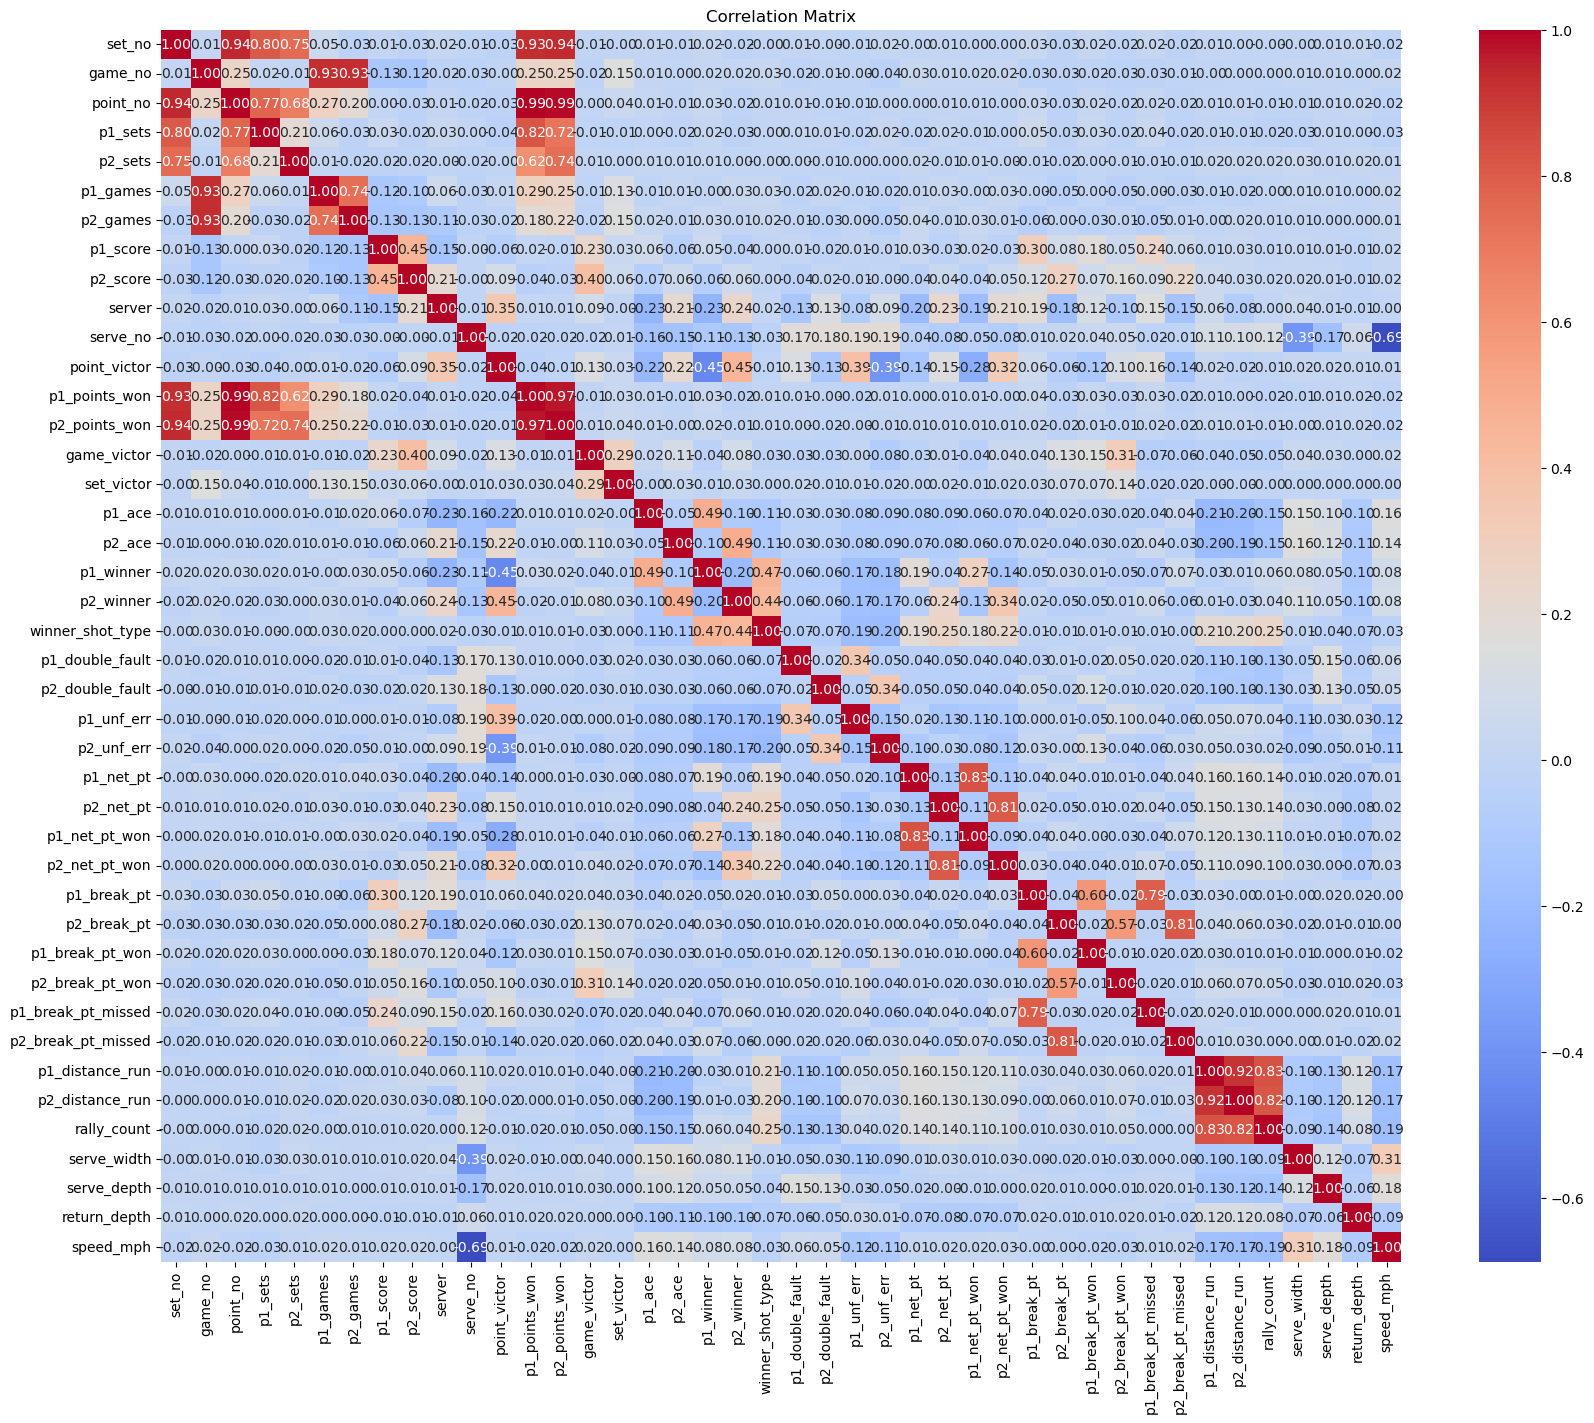

In [11]:
correlation_matrix = data.iloc[:, 4:].corr()

# 可视化相关性矩阵
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# 设置热图的标题
plt.title('Correlation Matrix')

# 显示图形
plt.show()

In [7]:
dcor_matrix = compute_dcor_matrix(data.iloc[:, 4:])
dcor_matrix

D:\Application\Anaconda3\lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
D:\Application\Anaconda3\lib\site-packages\dcor\_dcor_internals.py:188: RuntimeWarning: overflow encountered in longlong_scalars
  third_term = a_total_sum * b_total_sum / n_samples
D:\Application\Anaconda3\lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
D:\Application\Anaconda3\lib\site-packages\dcor\_fast_dcov_avl

array([[1.        , 0.03947603, 0.89066333, ..., 0.00881927, 0.01425537,
        0.02662597],
       [0.03947603, 1.        , 0.23296568, ..., 0.0112433 , 0.00643989,
        0.02740506],
       [0.89066333, 0.23296568, 0.        , ..., 0.01187792, 0.01649839,
        0.02633944],
       ...,
       [0.00881927, 0.0112433 , 0.01187792, ..., 1.        , 0.05682067,
        0.18228728],
       [0.01425537, 0.00643989, 0.01649839, ..., 0.05682067, 1.        ,
        0.09510502],
       [0.02662597, 0.02740506, 0.02633944, ..., 0.18228728, 0.09510502,
        1.        ]])

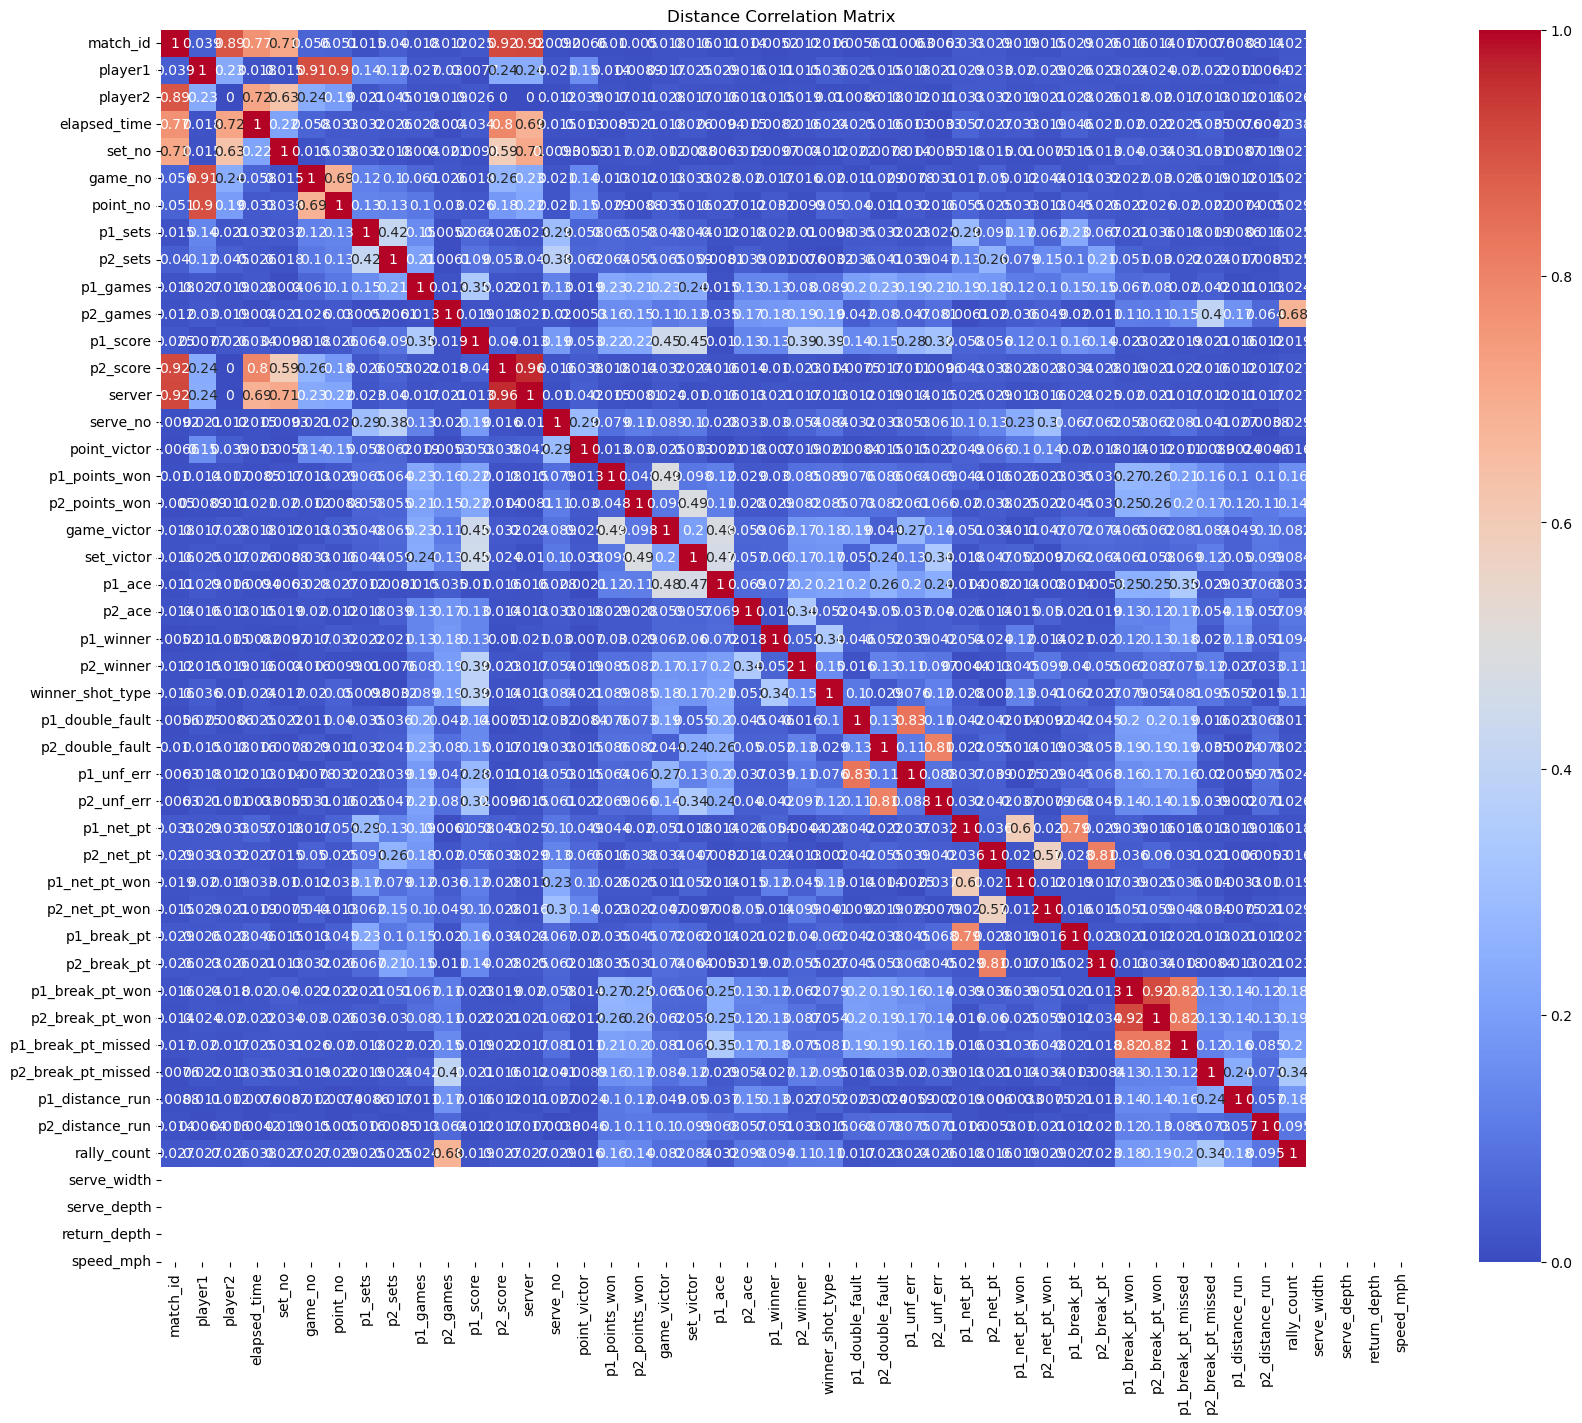

In [9]:
plt.figure(figsize=(20, 16))
sns.heatmap(dcor_matrix, annot=True, cmap='coolwarm', xticklabels=data.columns, yticklabels=data.columns)
plt.title('Distance Correlation Matrix')
plt.show()

In [6]:
data

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,serve_width,serve_depth,return_depth,speed_mph
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:00,1,1,1,0,0,0,...,0,0,0,6.000,7.840,2,1,1,1,95.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:38,1,1,2,0,0,0,...,0,0,0,5.253,7.094,1,2,2,1,118.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:01,1,1,3,0,0,0,...,0,0,0,13.800,19.808,4,2,1,2,120.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:31,1,1,4,0,0,0,...,0,0,0,51.108,75.631,13,3,2,2,130.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:02:21,1,1,5,0,0,0,...,0,0,0,0.649,0.813,1,4,1,1,112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:39:58,5,10,330,2,2,5,...,0,0,0,38.620,50.971,11,5,1,2,123.0
7280,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:40:43,5,10,331,2,2,5,...,0,0,0,17.533,27.766,5,4,1,1,114.0
7281,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:41:20,5,10,332,2,2,5,...,0,0,0,10.882,18.328,4,4,1,2,124.0
7282,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:41:52,5,10,333,2,2,5,...,0,0,0,7.893,10.537,1,5,1,2,130.0


In [2]:
wimbledon = pd.read_csv("./Wimbledon_featured_matches_new.csv")
wimbledon.head()

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,serve_width,serve_depth,return_depth,speed_mph
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:00,1,1,1,0,0,0,...,0,0,0,6.000,7.840,2,1,1,1,95.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:38,1,1,2,0,0,0,...,0,0,0,5.253,7.094,1,2,2,1,118.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:01,1,1,3,0,0,0,...,0,0,0,13.800,19.808,4,2,1,2,120.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:31,1,1,4,0,0,0,...,0,0,0,51.108,75.631,13,3,2,2,130.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:02:21,1,1,5,0,0,0,...,0,0,0,0.649,0.813,1,4,1,1,112.0


In [3]:
wimbledon['elapsed_time_td'] = pd.to_timedelta(wimbledon['elapsed_time'])
wimbledon['time_diff'] = wimbledon.groupby('match_id')['elapsed_time_td'].diff().dt.total_seconds()
wimbledon['time_diff'] = wimbledon.groupby('match_id')['time_diff'].fillna(
    wimbledon['elapsed_time_td'].dt.total_seconds()
)
wimbledon.loc[299: 304, ['match_id', 'elapsed_time', 'time_diff']]

,match_id,elapsed_time,time_diff
299,2023-wimbledon-1301,3:56:11,37.0
300,2023-wimbledon-1302,0:00:00,0.0
301,2023-wimbledon-1302,0:00:36,36.0
302,2023-wimbledon-1302,0:00:58,22.0
303,2023-wimbledon-1302,0:01:52,54.0
304,2023-wimbledon-1302,0:02:32,40.0


In [107]:
data = wimbledon.loc[:,['match_id', 'set_no', 'game_no','p1_sets', 'p2_sets', 'p1_games', 'p2_games', 
                        'p1_ace', 'p1_winner', 'p1_unf_err', 'p1_break_pt_won', 'p1_net_pt_won', 
                        'server', 'rally_count', 'speed_mph', 'p1_distance_run']]
data['server'] = data['server'].replace(2, -1)
data.head()

,match_id,set_no,game_no,p1_sets,p2_sets,p1_games,p2_games,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,rally_count,speed_mph,p1_distance_run
0,2023-wimbledon-1301,1,1,0,0,0,0,0,0,1,0,0,1,2,95.0,6.000
1,2023-wimbledon-1301,1,1,0,0,0,0,0,0,0,0,0,1,1,118.0,5.253
2,2023-wimbledon-1301,1,1,0,0,0,0,0,0,1,0,0,1,4,120.0,13.800
3,2023-wimbledon-1301,1,1,0,0,0,0,0,1,0,0,0,1,13,130.0,51.108
4,2023-wimbledon-1301,1,1,0,0,0,0,1,1,0,0,0,1,1,112.0,0.649


In [108]:
def select_variables(match_data, indicator, index, if_diff):
    grouped_data = match_data.groupby(['match_id', 'set_no', 'game_no'])[indicator].apply(lambda x: x.values.tolist()).reset_index(name=index)
    points_won_lists = grouped_data[index].tolist()
    if if_diff:
        points_won_lists = [[p1 - p2 for p1, p2 in match] for match in points_won_lists]
    return points_won_lists

In [109]:
def show_variables(ylabel, points_won_lists):
    np.random.seed(42)
    selected_indices = np.random.choice(len(points_won_lists), size=3, replace=False)
    selected_matches_diffs = [points_won_lists[i] for i in selected_indices]
    plt.figure(figsize=(12, 6))
    for i, match_diffs in enumerate(selected_matches_diffs, start=1):
        plt.subplot(1, 3, i)
        plt.plot(match_diffs, marker='o', linestyle='-', label=f'Match {selected_indices[i-1]}')
        plt.xlabel('Point Sequence')
        plt.ylabel(ylabel)
        plt.title(f'Match {selected_indices[i-1]} Point Difference')
        plt.axhline(y=0, color='grey', linestyle='--')
        plt.legend()
    plt.tight_layout()
    plt.show()

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]


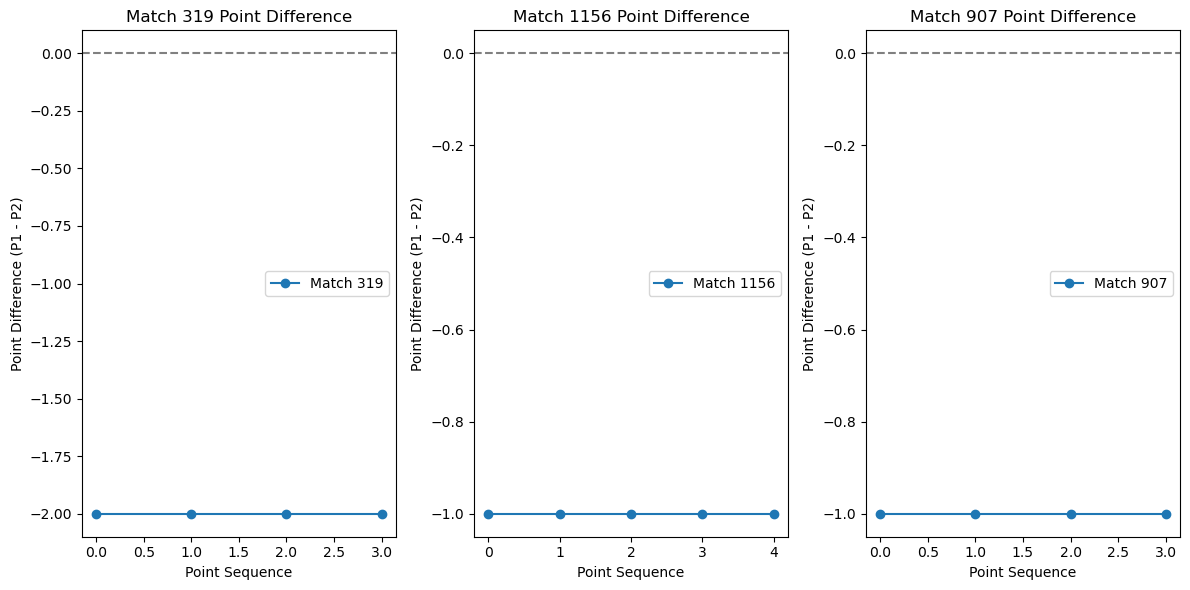

,match_id,set_no,game_no,p1_sets,p2_sets,p1_games,p2_games,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,rally_count,speed_mph,p1_distance_run,sets_won_list
0,2023-wimbledon-1301,1,1,0,0,0,0,0,0,1,0,0,1,2,95.0,6.000,0
1,2023-wimbledon-1301,1,1,0,0,0,0,0,0,0,0,0,1,1,118.0,5.253,0
2,2023-wimbledon-1301,1,1,0,0,0,0,0,0,1,0,0,1,4,120.0,13.800,0
3,2023-wimbledon-1301,1,1,0,0,0,0,0,1,0,0,0,1,13,130.0,51.108,0
4,2023-wimbledon-1301,1,1,0,0,0,0,1,1,0,0,0,1,1,112.0,0.649,0


In [110]:
points_won_lists = select_variables(data, ['p1_sets', 'p2_sets'], 'sets_won_list', True)
print(points_won_lists[:5])
show_variables('Point Difference (P1 - P2)', points_won_lists)
points_won_lists = [element for sublist in points_won_lists for element in sublist]
data['sets_won_list'] = points_won_lists
data.head()

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0], [1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0]]


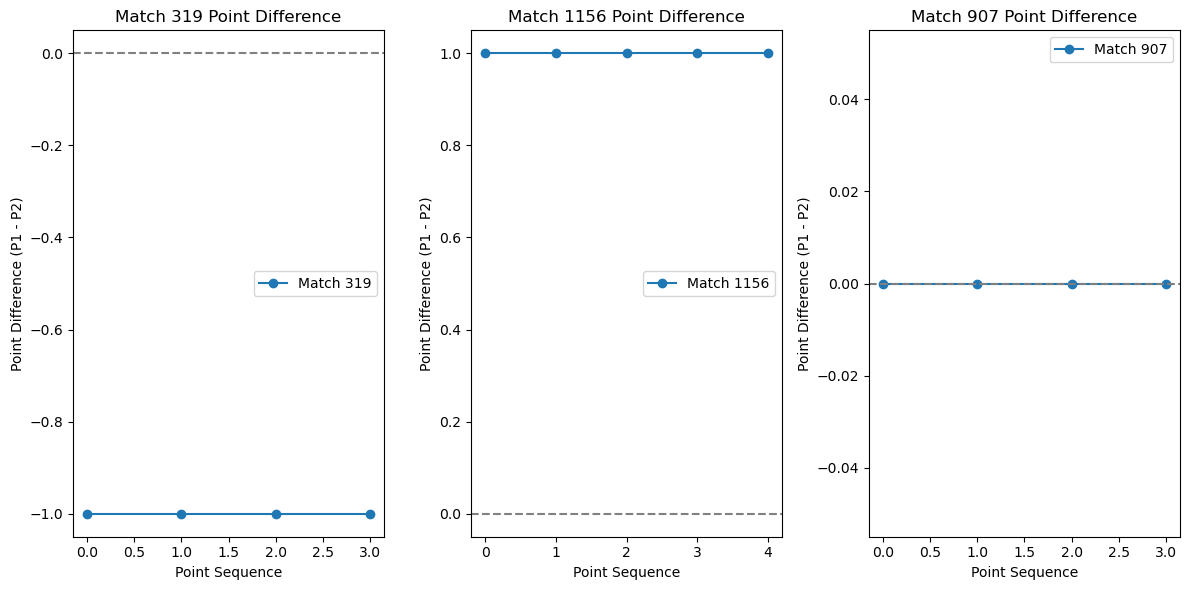

,match_id,set_no,game_no,p1_sets,p2_sets,p1_games,p2_games,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,rally_count,speed_mph,p1_distance_run,sets_won_list,games_won_list
0,2023-wimbledon-1301,1,1,0,0,0,0,0,0,1,0,0,1,2,95.0,6.000,0,0
1,2023-wimbledon-1301,1,1,0,0,0,0,0,0,0,0,0,1,1,118.0,5.253,0,0
2,2023-wimbledon-1301,1,1,0,0,0,0,0,0,1,0,0,1,4,120.0,13.800,0,0
3,2023-wimbledon-1301,1,1,0,0,0,0,0,1,0,0,0,1,13,130.0,51.108,0,0
4,2023-wimbledon-1301,1,1,0,0,0,0,1,1,0,0,0,1,1,112.0,0.649,0,0


In [111]:
points_won_lists = select_variables(data, ['p1_games', 'p2_games'], 'games_won_list', True)
print(points_won_lists[:5])
show_variables('Point Difference (P1 - P2)', points_won_lists)
points_won_lists = [element for sublist in points_won_lists for element in sublist]
data['games_won_list'] = points_won_lists
data.head()

In [112]:
data = data.drop(['match_id', 'set_no', 'game_no','p1_sets', 'p2_sets','p1_games', 'p2_games'], axis=1)
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,rally_count,speed_mph,p1_distance_run,sets_won_list,games_won_list
0,0,0,1,0,0,1,2,95.0,6.000,0,0
1,0,0,0,0,0,1,1,118.0,5.253,0,0
2,0,0,1,0,0,1,4,120.0,13.800,0,0
3,0,1,0,0,0,1,13,130.0,51.108,0,0
4,1,1,0,0,0,1,1,112.0,0.649,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,11,123.0,38.620,0,1
7280,0,1,0,0,1,1,5,114.0,17.533,0,1
7281,0,0,0,0,0,1,4,124.0,10.882,0,1
7282,0,0,0,0,0,1,1,130.0,7.893,0,1


In [113]:
d = wimbledon['point_victor']
d

0       2
1       1
2       2
3       1
4       1
       ..
7279    1
7280    1
7281    2
7282    1
7283    1
Name: point_victor, Length: 7284, dtype: int64

In [114]:
df = pd.read_excel('./单双发统计.xlsx')
df

,game,谁在发球,连发几个,二发失误,P1单发成功量,P2单发成功量,P1双发成功量,P2双发成功量,P1二发失误,P2二发失误,P1单发失误率,P2单发失误率,P1双发失误率,P2双发失误率
0,1,1,2,0,7,0,3,0,0,0,0.7,0.0,0.0,0
1,1,1,1,0,7,0,3,0,0,0,0.7,0.0,0.0,0
2,1,1,1,0,7,0,3,0,0,0,0.7,0.0,0.0,0
3,1,1,1,0,7,0,3,0,0,0,0.7,0.0,0.0,0
4,1,1,1,0,7,0,3,0,0,0,0.7,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,10,1,1,0,6,0,0,0,0,0,1.0,0.0,0.0,0
7280,10,1,1,0,6,0,0,0,0,0,1.0,0.0,0.0,0
7281,10,1,1,0,6,0,0,0,0,0,1.0,0.0,0.0,0
7282,10,1,1,0,6,0,0,0,0,0,1.0,0.0,0.0,0


In [115]:
df = df.loc[:, 'P1单发失误率']
df

0       0.7
1       0.7
2       0.7
3       0.7
4       0.7
       ... 
7279    1.0
7280    1.0
7281    1.0
7282    1.0
7283    1.0
Name: P1单发失误率, Length: 7284, dtype: float64

In [116]:
data = pd.concat([data, d], axis=1)
data = pd.concat([data, df], axis=1)
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,rally_count,speed_mph,p1_distance_run,sets_won_list,games_won_list,point_victor,P1单发失误率
0,0,0,1,0,0,1,2,95.0,6.000,0,0,2,0.7
1,0,0,0,0,0,1,1,118.0,5.253,0,0,1,0.7
2,0,0,1,0,0,1,4,120.0,13.800,0,0,2,0.7
3,0,1,0,0,0,1,13,130.0,51.108,0,0,1,0.7
4,1,1,0,0,0,1,1,112.0,0.649,0,0,1,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,11,123.0,38.620,0,1,1,1.0
7280,0,1,0,0,1,1,5,114.0,17.533,0,1,1,1.0
7281,0,0,0,0,0,1,4,124.0,10.882,0,1,2,1.0
7282,0,0,0,0,0,1,1,130.0,7.893,0,1,1,1.0


In [117]:
data['point_victor'] = data['point_victor'].replace(2, 0)
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,rally_count,speed_mph,p1_distance_run,sets_won_list,games_won_list,point_victor,P1单发失误率
0,0,0,1,0,0,1,2,95.0,6.000,0,0,0,0.7
1,0,0,0,0,0,1,1,118.0,5.253,0,0,1,0.7
2,0,0,1,0,0,1,4,120.0,13.800,0,0,0,0.7
3,0,1,0,0,0,1,13,130.0,51.108,0,0,1,0.7
4,1,1,0,0,0,1,1,112.0,0.649,0,0,1,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,11,123.0,38.620,0,1,1,1.0
7280,0,1,0,0,1,1,5,114.0,17.533,0,1,1,1.0
7281,0,0,0,0,0,1,4,124.0,10.882,0,1,0,1.0
7282,0,0,0,0,0,1,1,130.0,7.893,0,1,1,1.0


In [118]:
correlation = data.corr()['point_victor']
correlation

p1_ace             0.218704
p1_winner          0.445747
p1_unf_err        -0.388233
p1_break_pt_won    0.116130
p1_net_pt_won      0.278507
server             0.346817
rally_count        0.007546
speed_mph         -0.005137
p1_distance_run   -0.018772
sets_won_list      0.026005
games_won_list    -0.047838
point_victor       1.000000
P1单发失误率            0.315723
Name: point_victor, dtype: float64

In [119]:
t = wimbledon.drop(['match_id', 'set_no', 'game_no','p1_sets', 'p2_sets', 'p1_games', 'p2_games', 
                        'p1_ace', 'p1_winner', 'p1_unf_err', 'p1_break_pt_won', 'p1_net_pt_won', 
                        'server', 'rally_count', 'speed_mph', 'p1_distance_run'], axis=1)
t

,player1,player2,elapsed_time,point_no,p1_score,p2_score,serve_no,point_victor,p1_points_won,p2_points_won,...,p2_break_pt,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p2_distance_run,serve_width,serve_depth,return_depth,elapsed_time_td,time_diff
0,Carlos Alcaraz,Nicolas Jarry,0:00:00,1,0.0,0.0,2,2,0,1,...,0,0,0,0,7.840,1,1,1,0 days 00:00:00,0.0
1,Carlos Alcaraz,Nicolas Jarry,0:00:38,2,0.0,1.0,1,1,1,1,...,0,0,0,0,7.094,2,2,1,0 days 00:00:38,38.0
2,Carlos Alcaraz,Nicolas Jarry,0:01:01,3,1.0,1.0,1,2,1,2,...,0,0,0,0,19.808,2,1,2,0 days 00:01:01,23.0
3,Carlos Alcaraz,Nicolas Jarry,0:01:31,4,1.0,2.0,1,1,2,2,...,0,0,0,0,75.631,3,2,2,0 days 00:01:31,30.0
4,Carlos Alcaraz,Nicolas Jarry,0:02:21,5,2.0,2.0,1,1,3,2,...,0,0,0,0,0.813,4,1,1,0 days 00:02:21,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,Carlos Alcaraz,Novak Djokovic,4:39:58,330,0.0,1.0,1,1,165,165,...,0,0,0,0,50.971,5,1,2,0 days 04:39:58,27.0
7280,Carlos Alcaraz,Novak Djokovic,4:40:43,331,1.0,1.0,1,1,166,165,...,0,0,0,0,27.766,4,1,1,0 days 04:40:43,45.0
7281,Carlos Alcaraz,Novak Djokovic,4:41:20,332,2.0,1.0,1,2,166,166,...,0,0,0,0,18.328,4,1,2,0 days 04:41:20,37.0
7282,Carlos Alcaraz,Novak Djokovic,4:41:52,333,2.0,2.0,1,1,167,166,...,0,0,0,0,10.537,5,1,2,0 days 04:41:52,32.0


In [120]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
vif_data

,feature,VIF
0,p1_ace,1.580210
1,p1_winner,2.082258
2,p1_unf_err,1.405241
3,p1_break_pt_won,1.063361
4,p1_net_pt_won,1.317132
5,server,4.199241
6,rally_count,6.478883
7,speed_mph,7.284355
8,p1_distance_run,6.946286
9,sets_won_list,1.012924


In [121]:
# 计算距离相关系数
dist_corr = {}
for col in data.columns:
    if col != 'point_victor':
        dist_corr[col] = dcor.distance_correlation(data['point_victor'], data[col])

# 打印结果
for col, corr in dist_corr.items():
    print(f"Distance correlation between '{'point_victor'}' and '{col}': {corr}")


D:\Application\Anaconda3\lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
D:\Application\Anaconda3\lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


Distance correlation between 'point_victor' and 'p1_ace': 0.21870407663536096
Distance correlation between 'point_victor' and 'p1_winner': 0.445746898749028
Distance correlation between 'point_victor' and 'p1_unf_err': 0.38823336080608245
Distance correlation between 'point_victor' and 'p1_break_pt_won': 0.11612981398062279
Distance correlation between 'point_victor' and 'p1_net_pt_won': 0.2785072465373244
Distance correlation between 'point_victor' and 'server': 0.3468171104498313
Distance correlation between 'point_victor' and 'rally_count': 0.019049763330807736
Distance correlation between 'point_victor' and 'speed_mph': 0.018580328398078872
Distance correlation between 'point_victor' and 'p1_distance_run': 0.022534760370442993
Distance correlation between 'point_victor' and 'sets_won_list': 0.02263801605242325
Distance correlation between 'point_victor' and 'games_won_list': 0.06577895386286904
Distance correlation between 'point_victor' and 'P1单发失误率': 0.3212684152862685


In [122]:
def compute_dcor_matrix(df):
    n = df.shape[1]
    dcor_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            dcor_val = dcor.distance_correlation(df.iloc[:, i], df.iloc[:, j])
            dcor_matrix[i, j] = dcor_matrix[j, i] = dcor_val
    return dcor_matrix

In [123]:
dcor_matrix = compute_dcor_matrix(data)
dcor_matrix

D:\Application\Anaconda3\lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


array([[1.        , 0.49064632, 0.08490822, 0.02648065, 0.06350697,
        0.22796366, 0.20611209, 0.15837786, 0.27077316, 0.01268766,
        0.0630761 , 0.21870408, 0.22578367],
       [0.49064632, 1.        , 0.17305382, 0.01142004, 0.26913849,
        0.23371924, 0.08073339, 0.08183813, 0.06473769, 0.01278496,
        0.0570023 , 0.4457469 , 0.23391097],
       [0.08490822, 0.17305382, 1.        , 0.04508547, 0.1081258 ,
        0.07975686, 0.07534106, 0.11286422, 0.06204577, 0.01666843,
        0.02663329, 0.38823336, 0.06810944],
       [0.02648065, 0.01142004, 0.04508547, 1.        , 0.00248539,
        0.11616172, 0.03629816, 0.0194613 , 0.0393338 , 0.02742392,
        0.04401083, 0.11612981, 0.11585139],
       [0.06350697, 0.26913849, 0.1081258 , 0.00248539, 1.        ,
        0.18800433, 0.156523  , 0.02365505, 0.15586261, 0.01958216,
        0.05546858, 0.27850725, 0.18677516],
       [0.22796366, 0.23371924, 0.07975686, 0.11616172, 0.18800433,
        1.        , 0.02004

In [106]:
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,index,set_no,game_no
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10
7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10
7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10
7282,0,0,0,0,0,1,2023-wimbledon-1701,0.0,5,10


In [124]:
data.rename(columns={'P1单发失误率': 'Single serve error rate'}, inplace=True)

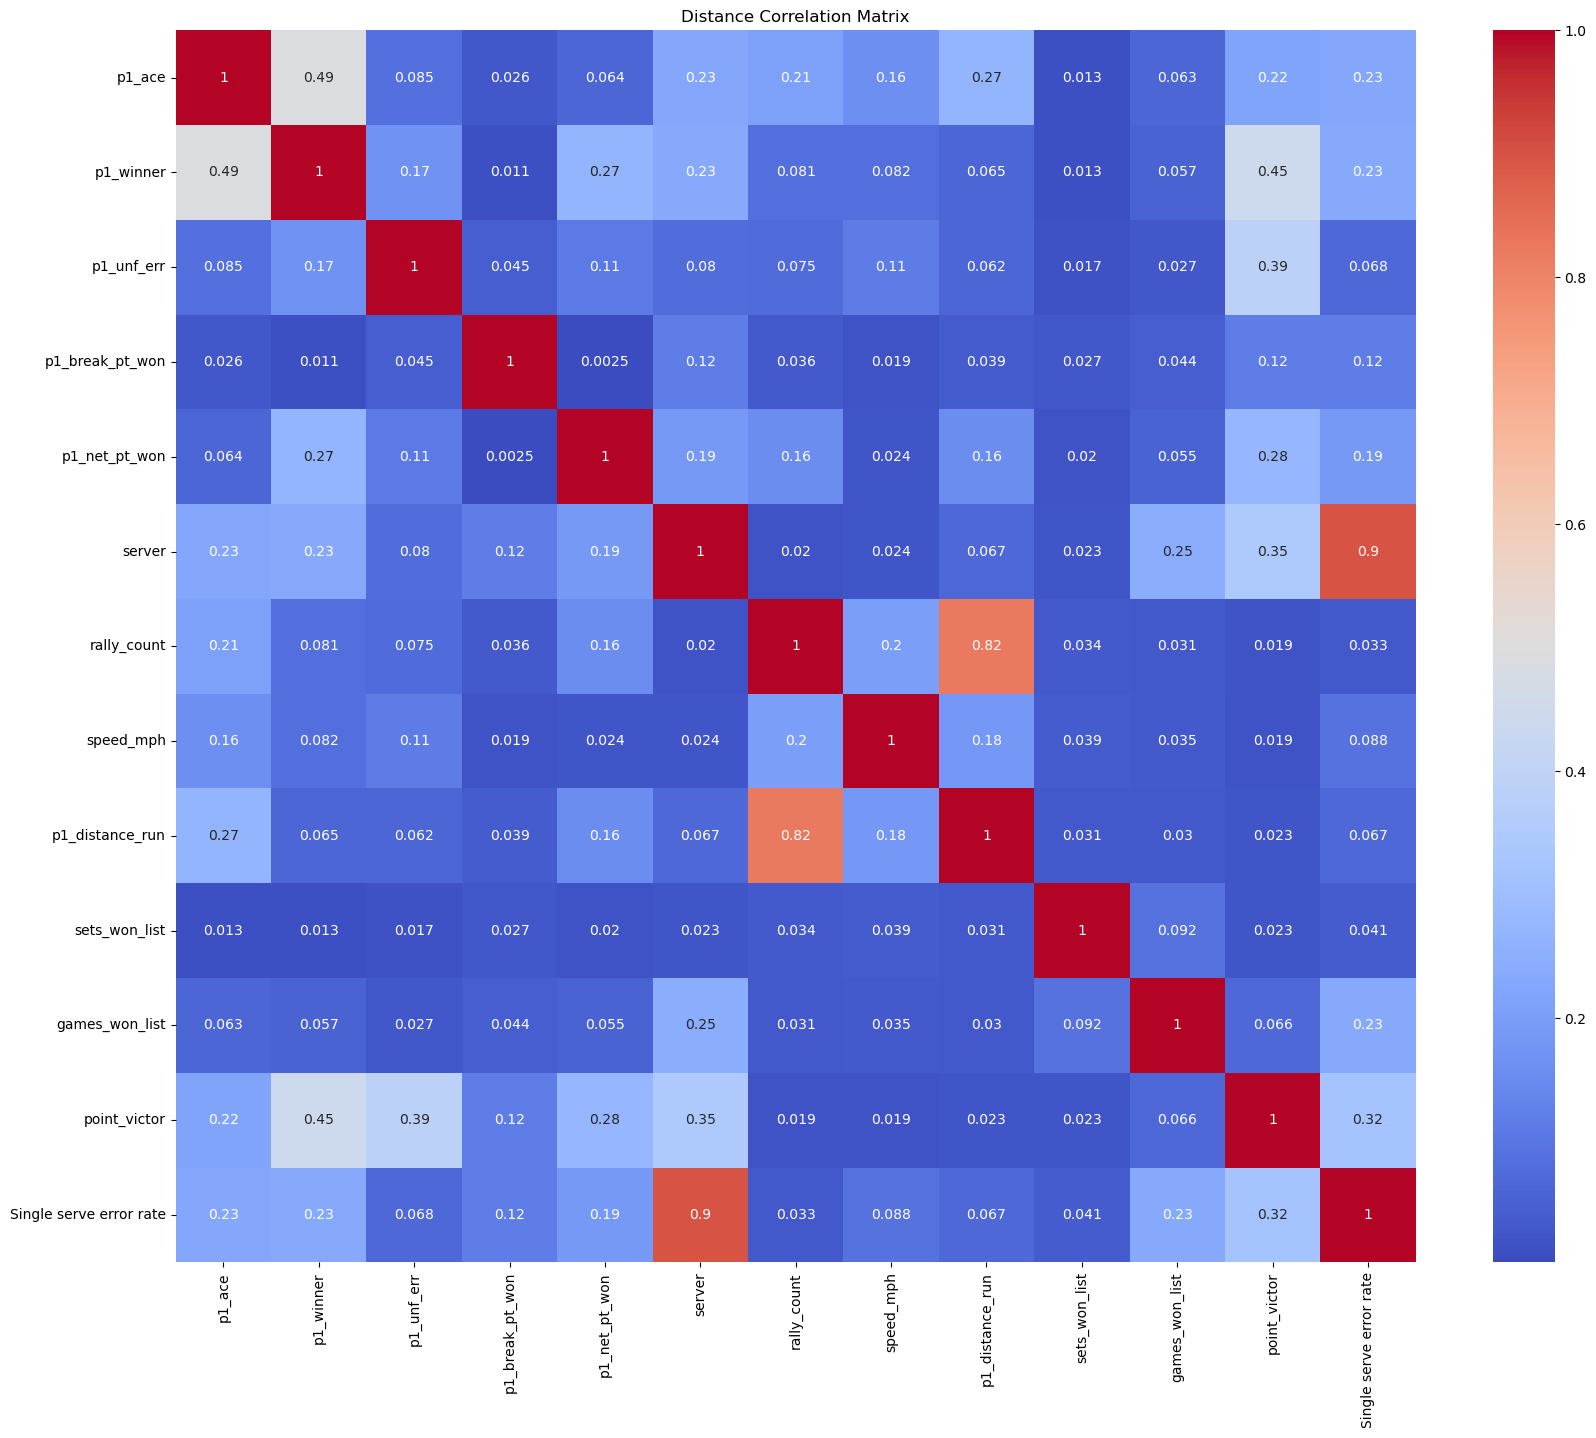

In [125]:
plt.figure(figsize=(20, 16))
sns.heatmap(dcor_matrix, annot=True, cmap='coolwarm', xticklabels=data.columns, yticklabels=data.columns)
plt.title('Distance Correlation Matrix')
svg_path = 'picture/distance_correlation.svg'
plt.savefig(svg_path, format='svg', bbox_inches='tight')
plt.show()

In [57]:
correlations = {}
for col in data:
    corr, _ = spearmanr(data['point_victor'], data[col])
    correlations[col] = corr
correlation

p1_ace             0.218704
p1_winner          0.445747
p1_unf_err        -0.388233
p1_break_pt_won    0.116130
p1_net_pt_won      0.278507
server             0.346817
rally_count        0.007546
speed_mph         -0.005137
p1_distance_run   -0.018772
sets_won_list      0.026005
games_won_list    -0.047838
point_victor       1.000000
P1单发失误率            0.315723
Name: point_victor, dtype: float64

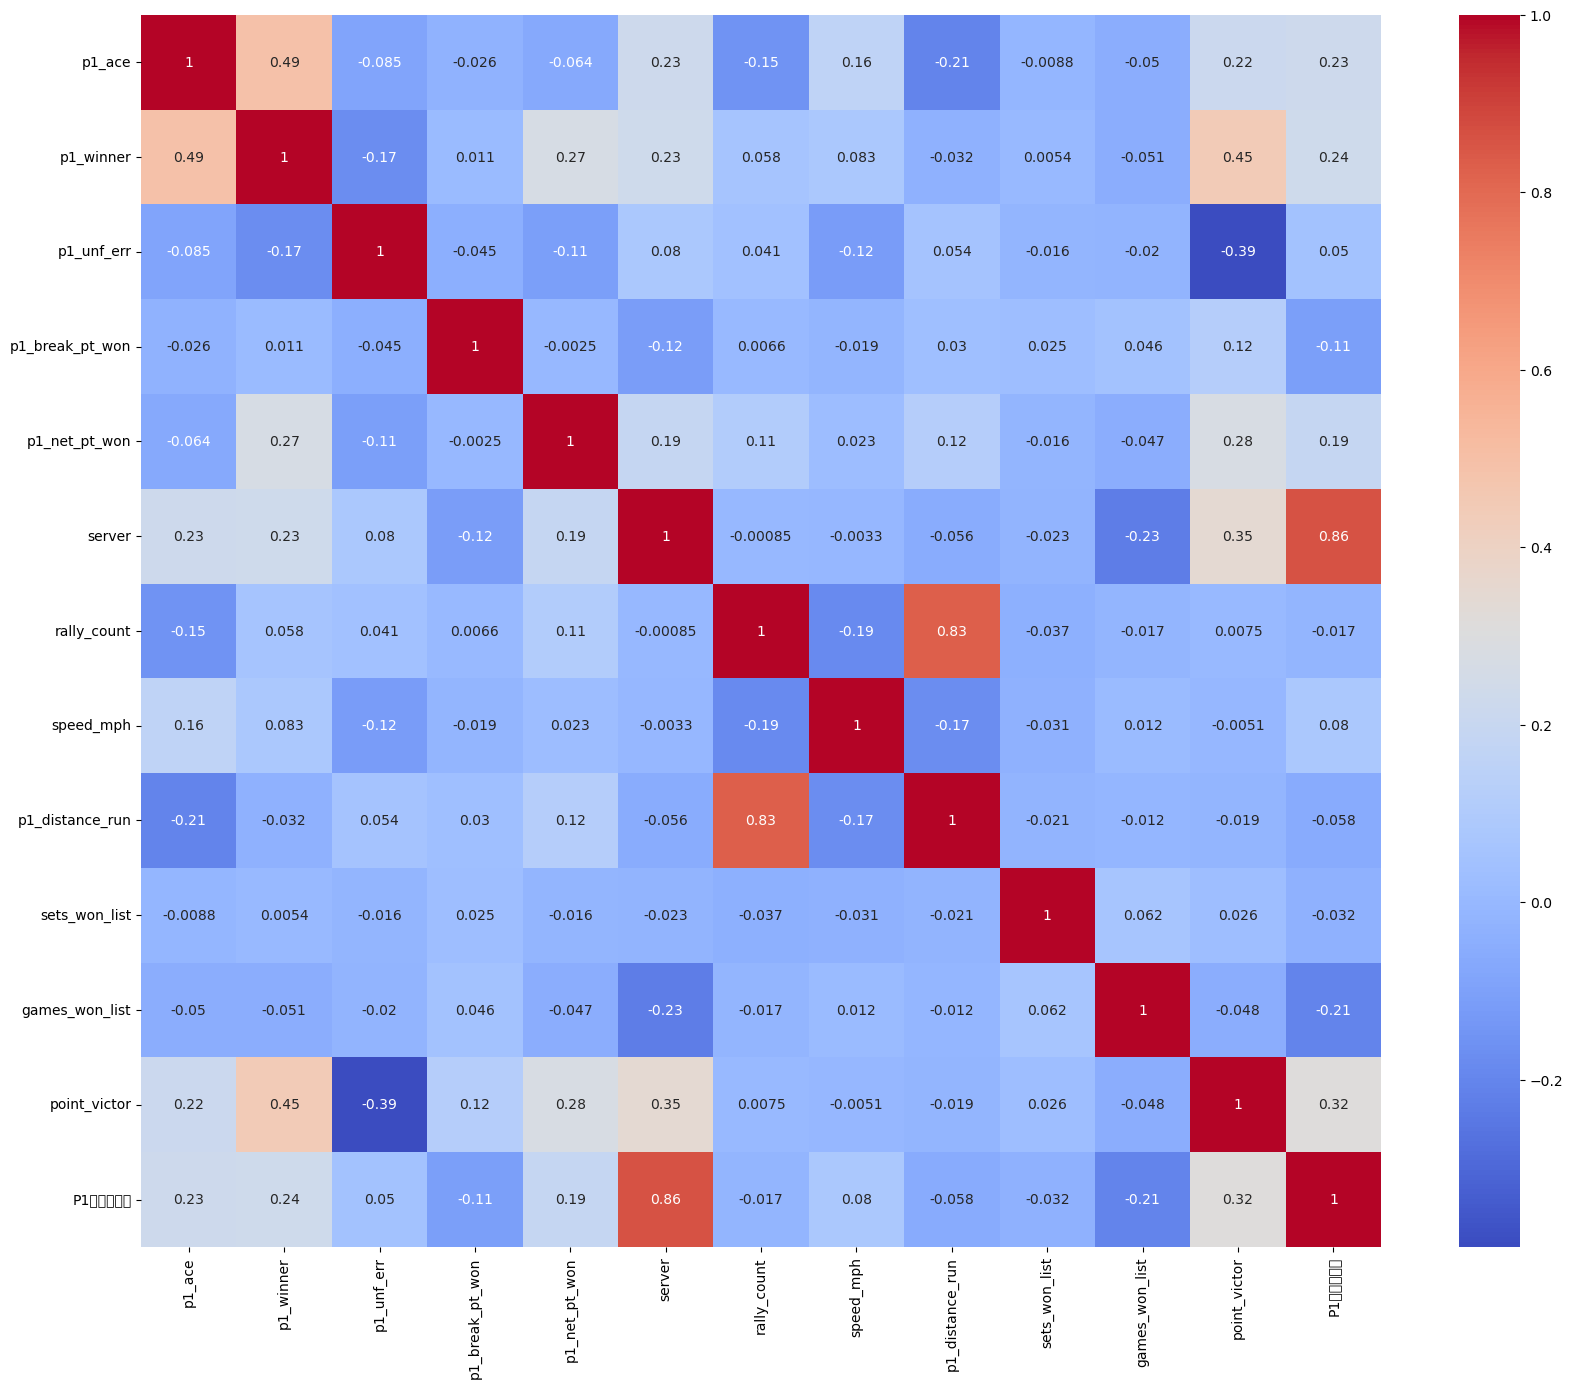

In [43]:
plt.figure(figsize=(20, 16))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [27]:
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,rally_count,speed_mph,p1_distance_run,sets_won_list,games_won_list,point_victor,Single serve error rate
0,0,0,1,0,0,1,2,95.0,6.000,0,0,0,0.7
1,0,0,0,0,0,1,1,118.0,5.253,0,0,1,0.7
2,0,0,1,0,0,1,4,120.0,13.800,0,0,0,0.7
3,0,1,0,0,0,1,13,130.0,51.108,0,0,1,0.7
4,1,1,0,0,0,1,1,112.0,0.649,0,0,1,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,11,123.0,38.620,0,1,1,1.0
7280,0,1,0,0,1,1,5,114.0,17.533,0,1,1,1.0
7281,0,0,0,0,0,1,4,124.0,10.882,0,1,0,1.0
7282,0,0,0,0,0,1,1,130.0,7.893,0,1,1,1.0


In [29]:
data['server'] = data['server'].replace(2, 0)
data['server'][12]

0

In [28]:
data = wimbledon.loc[:, ['p1_ace', 'p1_winner', 'p1_unf_err', 'p1_break_pt_won', 'p1_net_pt_won', 'server']]
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server
0,0,0,1,0,0,1
1,0,0,0,0,0,1
2,0,0,1,0,0,1
3,0,1,0,0,0,1
4,1,1,0,0,0,1
...,...,...,...,...,...,...
7279,0,1,0,0,0,1
7280,0,1,0,0,1,1
7281,0,0,0,0,0,1
7282,0,0,0,0,0,1


In [30]:
data['server']

0       1
1       1
2       1
3       1
4       1
       ..
7279    1
7280    1
7281    1
7282    1
7283    1
Name: server, Length: 7284, dtype: int64

In [31]:
data = pd.concat([data, wimbledon['match_id']], axis=True)
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id
0,0,0,1,0,0,1,2023-wimbledon-1301
1,0,0,0,0,0,1,2023-wimbledon-1301
2,0,0,1,0,0,1,2023-wimbledon-1301
3,0,1,0,0,0,1,2023-wimbledon-1301
4,1,1,0,0,0,1,2023-wimbledon-1301
...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701
7280,0,1,0,0,1,1,2023-wimbledon-1701
7281,0,0,0,0,0,1,2023-wimbledon-1701
7282,0,0,0,0,0,1,2023-wimbledon-1701


In [32]:
d1 = data.copy()
result_df = pd.DataFrame()
groups = data.groupby('match_id')
for group_name, group_data in groups:
    # 取出每个组的第二行至最后一行
    group_data = group_data.iloc[:-1]
    # 添加一个新的第一行
    new_row = pd.Series([0] * len(data.columns), index=data.columns)
    new_row['match_id'] = group_name
    group_data = pd.concat([pd.DataFrame(new_row).transpose(), group_data])
    # 将结果添加到结果 DataFrame 中
    result_df = pd.concat([result_df, group_data])
result_df

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id
0,0,0,0,0,0,0,2023-wimbledon-1301
0,0,0,1,0,0,1,2023-wimbledon-1301
1,0,0,0,0,0,1,2023-wimbledon-1301
2,0,0,1,0,0,1,2023-wimbledon-1301
3,0,1,0,0,0,1,2023-wimbledon-1301
...,...,...,...,...,...,...,...
7278,0,0,1,0,0,1,2023-wimbledon-1701
7279,0,1,0,0,0,1,2023-wimbledon-1701
7280,0,1,0,0,1,1,2023-wimbledon-1701
7281,0,0,0,0,0,1,2023-wimbledon-1701


In [33]:
result_df.loc[298:301, :]

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id
298,0,0,0,0,0,1,2023-wimbledon-1301
0,0,0,0,0,0,0,2023-wimbledon-1302
300,0,0,0,0,0,0,2023-wimbledon-1302
301,0,0,0,0,0,0,2023-wimbledon-1302


In [34]:
def calculate_momentum_improved(da, index):
    dd = pd.DataFrame()
    
    dd['index'] = da['p1_ace'] * 0.062 + da['p1_winner']*0.405 - da['p1_unf_err']*0.213 
    + da['p1_break_pt_won'] * 0.0325 + da['p1_net_pt_won']*0.106 + da['server']*0.181
    
    return dd['index']

In [35]:
result_df

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id
0,0,0,0,0,0,0,2023-wimbledon-1301
0,0,0,1,0,0,1,2023-wimbledon-1301
1,0,0,0,0,0,1,2023-wimbledon-1301
2,0,0,1,0,0,1,2023-wimbledon-1301
3,0,1,0,0,0,1,2023-wimbledon-1301
...,...,...,...,...,...,...,...
7278,0,0,1,0,0,1,2023-wimbledon-1701
7279,0,1,0,0,0,1,2023-wimbledon-1701
7280,0,1,0,0,1,1,2023-wimbledon-1701
7281,0,0,0,0,0,1,2023-wimbledon-1701


In [36]:
df = calculate_momentum_improved(result_df, 'p1')
df

0         0.0
0      -0.213
1         0.0
2      -0.213
3       0.405
        ...  
7278   -0.213
7279    0.405
7280    0.405
7281      0.0
7282      0.0
Name: index, Length: 7284, dtype: object

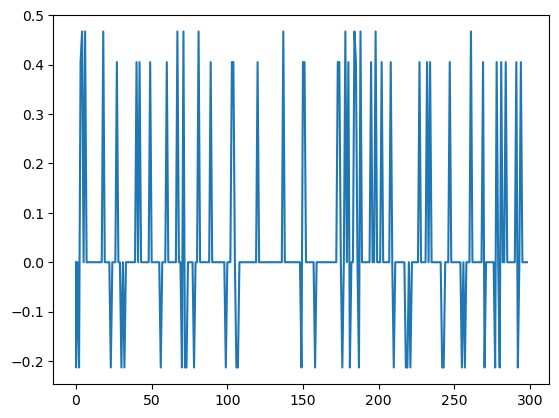

In [37]:
plt.plot(df[:300])
plt.show()

In [38]:
data1 = wimbledon.loc[:, ['p2_ace', 'p2_winner', 'p2_unf_err', 'p2_break_pt_won', 'p2_net_pt_won', 'server', 'match_id']]
data1

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id
0,0,0,0,0,0,1,2023-wimbledon-1301
1,0,0,0,0,0,1,2023-wimbledon-1301
2,0,0,0,0,0,1,2023-wimbledon-1301
3,0,0,0,0,0,1,2023-wimbledon-1301
4,0,0,0,0,0,1,2023-wimbledon-1301
...,...,...,...,...,...,...,...
7279,0,0,0,0,0,1,2023-wimbledon-1701
7280,0,0,0,0,0,1,2023-wimbledon-1701
7281,0,1,0,0,0,1,2023-wimbledon-1701
7282,0,0,0,0,0,1,2023-wimbledon-1701


In [39]:
data1['server']

0       1
1       1
2       1
3       1
4       1
       ..
7279    1
7280    1
7281    1
7282    1
7283    1
Name: server, Length: 7284, dtype: int64

In [40]:
data1['server'] = data1['server'].replace(1, 0)
data1['server'] = data1['server'].replace(2, 1)
data1['server'][12]

1

In [41]:
d = data1.copy()
result_df = pd.DataFrame()
groups = data1.groupby('match_id')
for group_name, group_data in groups:
    # 取出每个组的第二行至最后一行
    group_data = group_data.iloc[:-1]
    # 添加一个新的第一行
    new_row = pd.Series([0] * len(data1.columns), index=data1.columns)
    new_row['match_id'] = group_name
    group_data = pd.concat([pd.DataFrame(new_row).transpose(), group_data])
    # 将结果添加到结果 DataFrame 中
    result_df = pd.concat([result_df, group_data])
result_df

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id
0,0,0,0,0,0,0,2023-wimbledon-1301
0,0,0,0,0,0,0,2023-wimbledon-1301
1,0,0,0,0,0,0,2023-wimbledon-1301
2,0,0,0,0,0,0,2023-wimbledon-1301
3,0,0,0,0,0,0,2023-wimbledon-1301
...,...,...,...,...,...,...,...
7278,0,0,0,0,0,0,2023-wimbledon-1701
7279,0,0,0,0,0,0,2023-wimbledon-1701
7280,0,0,0,0,0,0,2023-wimbledon-1701
7281,0,1,0,0,0,0,2023-wimbledon-1701


In [42]:
result_df.loc[298:301, :]

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id
298,0,0,0,0,0,0,2023-wimbledon-1301
0,0,0,0,0,0,0,2023-wimbledon-1302
300,0,0,1,0,0,1,2023-wimbledon-1302
301,0,0,0,0,0,1,2023-wimbledon-1302


In [44]:
df1 = calculate_momentum_improved1(data1, 'p2')
df1

0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
        ...  
7279    0.000
7280    0.000
7281    0.405
7282    0.000
7283    0.000
Length: 7284, dtype: float64

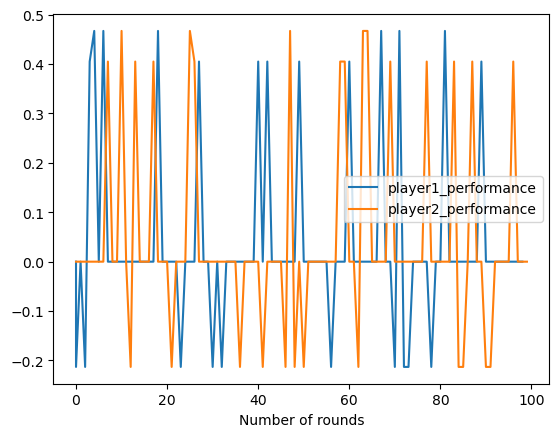

In [105]:
plt.plot(df[:100], label='player1_performance')
plt.plot(df1[:100], label='player2_performance')
plt.legend()
plt.xlabel('Number of rounds')
svg_path = 'picture/Q1performance.svg'
plt.savefig(svg_path, format='svg', bbox_inches='tight')
plt.show()

In [175]:
data1 = d
data1

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id
0,0,0,0,0,0,0,2023-wimbledon-1301
1,0,0,0,0,0,0,2023-wimbledon-1301
2,0,0,0,0,0,0,2023-wimbledon-1301
3,0,0,0,0,0,0,2023-wimbledon-1301
4,0,0,0,0,0,0,2023-wimbledon-1301
...,...,...,...,...,...,...,...
7279,0,0,0,0,0,0,2023-wimbledon-1701
7280,0,0,0,0,0,0,2023-wimbledon-1701
7281,0,1,0,0,0,0,2023-wimbledon-1701
7282,0,0,0,0,0,0,2023-wimbledon-1701


In [265]:
data1 = (data1 - data1.mean()) / data1.std()
data1

C:\Users\28266\AppData\Local\Temp\ipykernel_41132\1213502010.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data1 = (data1 - data1.mean()) / data1.std()
C:\Users\28266\AppData\Local\Temp\ipykernel_41132\1213502010.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data1 = (data1 - data1.mean()) / data1.std()


,match_id,p2_ace,p2_break_pt_won,p2_net_pt_won,p2_unf_err,p2_winner,server
0,NaN,-0.214346,-0.102676,-0.309547,-0.396574,-0.440314,-1.020739
1,NaN,-0.214346,-0.102676,-0.309547,-0.396574,-0.440314,-1.020739
2,NaN,-0.214346,-0.102676,-0.309547,-0.396574,-0.440314,-1.020739
3,NaN,-0.214346,-0.102676,-0.309547,-0.396574,-0.440314,-1.020739
4,NaN,-0.214346,-0.102676,-0.309547,-0.396574,-0.440314,-1.020739
...,...,...,...,...,...,...,...
7279,NaN,-0.214346,-0.102676,-0.309547,-0.396574,-0.440314,-1.020739
7280,NaN,-0.214346,-0.102676,-0.309547,-0.396574,-0.440314,-1.020739
7281,NaN,-0.214346,-0.102676,-0.309547,-0.396574,2.270797,-1.020739
7282,NaN,-0.214346,-0.102676,-0.309547,-0.396574,-0.440314,-1.020739


In [43]:
def calculate_momentum_improved1(da, index):
    
    dd = da['p2_ace'] * 0.062 + da['p2_winner']*0.405 - da['p2_unf_err']*0.213 
    + da['p2_break_pt_won'] * 0.0325 + da['p2_net_pt_won']*0.106 + da['server']*0.181
    
    return dd

In [267]:
df1 = calculate_momentum_improved1(data1, 'p2')

In [268]:
df1

0      -0.107146
1      -0.107146
2      -0.107146
3      -0.107146
4      -0.107146
          ...   
7279   -0.107146
7280   -0.107146
7281    0.990854
7282   -0.107146
7283   -0.107146
Length: 7284, dtype: float64

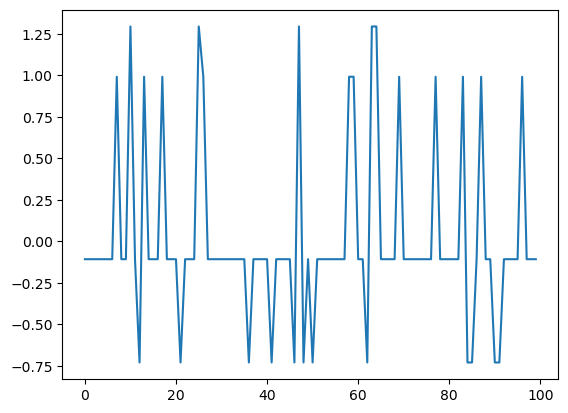

In [269]:
plt.plot(df1[:100])

In [270]:
data = (data - data.mean()) / data.std()
data

C:\Users\28266\AppData\Local\Temp\ipykernel_41132\109010169.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = (data - data.mean()) / data.std()
C:\Users\28266\AppData\Local\Temp\ipykernel_41132\109010169.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = (data - data.mean()) / data.std()


,match_id,p1_ace,p1_break_pt_won,p1_net_pt_won,p1_unf_err,p1_winner,server
0,NaN,-0.223301,-0.118571,-0.284361,2.629913,-0.455116,1.020739
1,NaN,-0.223301,-0.118571,-0.284361,-0.380189,-0.455116,1.020739
2,NaN,-0.223301,-0.118571,-0.284361,2.629913,-0.455116,1.020739
3,NaN,-0.223301,-0.118571,-0.284361,-0.380189,2.196938,1.020739
4,NaN,4.477641,-0.118571,-0.284361,-0.380189,2.196938,1.020739
...,...,...,...,...,...,...,...
7279,NaN,-0.223301,-0.118571,-0.284361,-0.380189,2.196938,1.020739
7280,NaN,-0.223301,-0.118571,3.516168,-0.380189,2.196938,1.020739
7281,NaN,-0.223301,-0.118571,-0.284361,-0.380189,-0.455116,1.020739
7282,NaN,-0.223301,-0.118571,-0.284361,-0.380189,-0.455116,1.020739


In [271]:
df = calculate_momentum_improved(data, 'p1')

In [272]:
df

0      -0.758338
1      -0.117187
2      -0.758338
3       0.956895
4       1.248354
          ...   
7279    0.956895
7280    0.956895
7281   -0.117187
7282   -0.117187
7283   -0.117187
Name: index, Length: 7284, dtype: float64

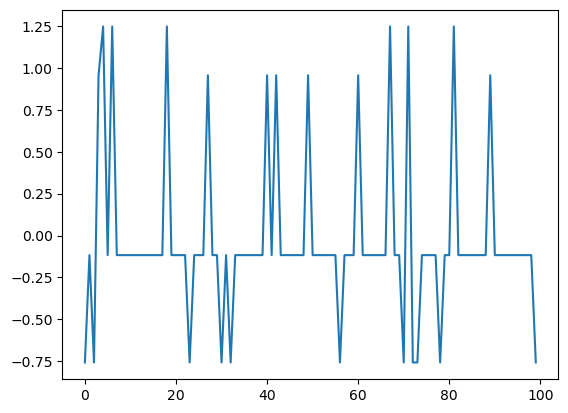

In [273]:
plt.plot(df[:100])

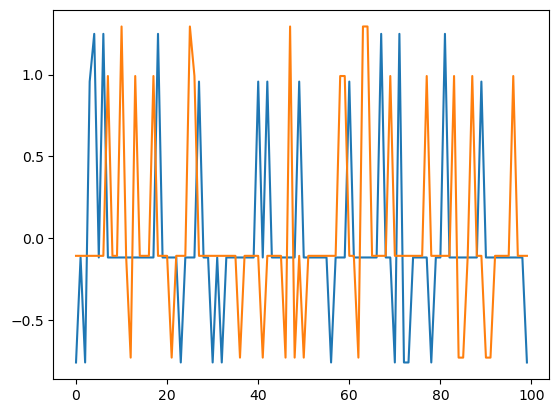

In [274]:
plt.plot(df[:100])
plt.plot(df1[:100])

In [33]:
data1

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id
0,0,0,0,0,0,0,2023-wimbledon-1301
1,0,0,0,0,0,0,2023-wimbledon-1301
2,0,0,0,0,0,0,2023-wimbledon-1301
3,0,0,0,0,0,0,2023-wimbledon-1301
4,0,0,0,0,0,0,2023-wimbledon-1301
...,...,...,...,...,...,...,...
7279,0,0,0,0,0,0,2023-wimbledon-1701
7280,0,0,0,0,0,0,2023-wimbledon-1701
7281,0,1,0,0,0,0,2023-wimbledon-1701
7282,0,0,0,0,0,0,2023-wimbledon-1701


In [34]:
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id
0,0,0,1,0,0,1,2023-wimbledon-1301
1,0,0,0,0,0,1,2023-wimbledon-1301
2,0,0,1,0,0,1,2023-wimbledon-1301
3,0,1,0,0,0,1,2023-wimbledon-1301
4,1,1,0,0,0,1,2023-wimbledon-1301
...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701
7280,0,1,0,0,1,1,2023-wimbledon-1701
7281,0,0,0,0,0,1,2023-wimbledon-1701
7282,0,0,0,0,0,1,2023-wimbledon-1701


In [51]:
data1 = pd.concat([data1, df1.reset_index(drop=True)], axis=1)
data1

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id,0
0,0,0,0,0,0,0,2023-wimbledon-1301,0.000
1,0,0,0,0,0,0,2023-wimbledon-1301,0.000
2,0,0,0,0,0,0,2023-wimbledon-1301,0.000
3,0,0,0,0,0,0,2023-wimbledon-1301,0.000
4,0,0,0,0,0,0,2023-wimbledon-1301,0.000
...,...,...,...,...,...,...,...,...
7279,0,0,0,0,0,0,2023-wimbledon-1701,0.000
7280,0,0,0,0,0,0,2023-wimbledon-1701,0.000
7281,0,1,0,0,0,0,2023-wimbledon-1701,0.405
7282,0,0,0,0,0,0,2023-wimbledon-1701,0.000


In [52]:
data = pd.concat([data, df.reset_index(drop=True)], axis=1)
data = data.rename(columns={0: 'p1_score'})
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,index
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405
...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213
7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405
7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405
7282,0,0,0,0,0,1,2023-wimbledon-1701,0.0


In [53]:
data = pd.concat([data, wimbledon['set_no']], axis=1)
data = pd.concat([data, wimbledon['game_no']], axis=1)
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,index,set_no,game_no
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10
7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10
7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10
7282,0,0,0,0,0,1,2023-wimbledon-1701,0.0,5,10


In [54]:
data1 = pd.concat([data1, wimbledon['set_no']], axis=1)
data1 = pd.concat([data1, wimbledon['game_no']], axis=1)
data1

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id,0,set_no,game_no
0,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
1,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
2,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
3,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
4,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
...,...,...,...,...,...,...,...,...,...,...
7279,0,0,0,0,0,0,2023-wimbledon-1701,0.000,5,10
7280,0,0,0,0,0,0,2023-wimbledon-1701,0.000,5,10
7281,0,1,0,0,0,0,2023-wimbledon-1701,0.405,5,10
7282,0,0,0,0,0,0,2023-wimbledon-1701,0.000,5,10


In [326]:
data = d1
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id
0,0,0,1,0,0,1,2023-wimbledon-1301
1,0,0,0,0,0,1,2023-wimbledon-1301
2,0,0,1,0,0,1,2023-wimbledon-1301
3,0,1,0,0,0,1,2023-wimbledon-1301
4,1,1,0,0,0,1,2023-wimbledon-1301
...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701
7280,0,1,0,0,1,1,2023-wimbledon-1701
7281,0,0,0,0,0,1,2023-wimbledon-1701
7282,0,0,0,0,0,1,2023-wimbledon-1701


In [318]:
data.columns

Index(['p1_ace', 'p1_winner', 'p1_unf_err', 'p1_break_pt_won', 'p1_net_pt_won',
       'server', 'match_id', 'p1_score', 'set_no', 'game_no', 'p1_score'],
      dtype='object')

In [57]:
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,index,set_no,game_no
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10
7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10
7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10
7282,0,0,0,0,0,1,2023-wimbledon-1701,0.0,5,10


In [143]:
t1 = data[(data['match_id'] == '2023-wimbledon-1301') & (data['set_no'] == 1)]
t1

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,index,set_no,game_no
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...
58,0,0,0,0,0,1,2023-wimbledon-1301,0.0,1,9
59,0,0,0,0,0,1,2023-wimbledon-1301,0.0,1,9
60,0,1,0,0,0,1,2023-wimbledon-1301,0.0,1,9
61,0,0,0,0,0,1,2023-wimbledon-1301,0.405,1,9


In [55]:
t1 = data[data['match_id'] == '2023-wimbledon-1301']
t1

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,index,set_no,game_no
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,0,1,2023-wimbledon-1301,0.405,4,12
296,0,0,0,0,0,1,2023-wimbledon-1301,0.0,4,12
297,0,0,0,0,0,1,2023-wimbledon-1301,0.0,4,12
298,0,0,0,0,0,1,2023-wimbledon-1301,0.0,4,12


In [56]:
grouped_data = t1.groupby(['match_id', 'set_no', 'game_no'])['index'].sum().values
points_won_lists = np.array(grouped_data).tolist()
points_won_lists

[0.913,
 0.0,
 0.467,
 -0.213,
 -0.020999999999999963,
 0.0,
 0.81,
 0.405,
 0.19200000000000003,
 0.0,
 0.29500000000000015,
 0.0,
 0.254,
 0.405,
 0.19200000000000003,
 -0.020999999999999963,
 0.0,
 0.405,
 0.0,
 0.0,
 0.467,
 0.5970000000000001,
 -0.213,
 0.0,
 0.5970000000000001,
 0.6590000000000001,
 0.6590000000000001,
 0.467,
 0.405,
 0.8720000000000001,
 0.19200000000000003,
 0.0,
 -0.639,
 1.215,
 -0.020999999999999963,
 -0.213,
 -0.213,
 0.467,
 0.19200000000000003,
 0.0,
 0.7890000000000001,
 0.0,
 0.5970000000000001]

In [57]:
grouped_data = t1.groupby(['match_id', 'set_no', 'game_no'])['index'].sum().values
points_won_lists = np.array(grouped_data).tolist()
points_won_lists

[0.913,
 0.0,
 0.467,
 -0.213,
 -0.020999999999999963,
 0.0,
 0.81,
 0.405,
 0.19200000000000003,
 0.0,
 0.29500000000000015,
 0.0,
 0.254,
 0.405,
 0.19200000000000003,
 -0.020999999999999963,
 0.0,
 0.405,
 0.0,
 0.0,
 0.467,
 0.5970000000000001,
 -0.213,
 0.0,
 0.5970000000000001,
 0.6590000000000001,
 0.6590000000000001,
 0.467,
 0.405,
 0.8720000000000001,
 0.19200000000000003,
 0.0,
 -0.639,
 1.215,
 -0.020999999999999963,
 -0.213,
 -0.213,
 0.467,
 0.19200000000000003,
 0.0,
 0.7890000000000001,
 0.0,
 0.5970000000000001]

In [60]:
t2 = data1[(data1['match_id'] == '2023-wimbledon-1301') & (data1['set_no'] == 1)]
t2

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id,0,set_no,game_no
0,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
1,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
2,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
3,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
4,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
...,...,...,...,...,...,...,...,...,...,...
58,0,1,0,0,1,0,2023-wimbledon-1301,0.405,1,9
59,0,1,0,0,1,0,2023-wimbledon-1301,0.405,1,9
60,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,9
61,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,9


In [58]:
t2 = data1[data1['match_id'] == '2023-wimbledon-1301']
t2

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id,0,set_no,game_no
0,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
1,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
2,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
3,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
4,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,0,0,2023-wimbledon-1301,0.000,4,12
296,0,1,0,0,0,0,2023-wimbledon-1301,0.405,4,12
297,0,0,0,0,0,0,2023-wimbledon-1301,0.000,4,12
298,0,0,0,0,0,0,2023-wimbledon-1301,0.000,4,12


In [59]:
tmp = t1['index'] - t2[0]
tmp

0        0.0
1     -0.213
2        0.0
3     -0.213
4      0.405
       ...  
295    0.405
296   -0.405
297      0.0
298      0.0
299      0.0
Length: 300, dtype: object

In [60]:
grouped_data1 = t2.groupby(['match_id', 'set_no', 'game_no'])[0].sum().values
points_won_lists1 = np.array(grouped_data1).tolist()
points_won_lists1

[0.405,
 1.064,
 -0.213,
 0.8720000000000001,
 0.0,
 -0.213,
 -0.213,
 -0.17199999999999993,
 0.5970000000000001,
 0.934,
 0.405,
 0.405,
 -0.020999999999999963,
 0.38400000000000006,
 0.405,
 -0.2549999999999999,
 -0.213,
 0.934,
 -0.213,
 0.254,
 0.0,
 0.8720000000000001,
 -0.213,
 0.9810000000000002,
 0.19200000000000003,
 -0.426,
 -0.213,
 0.5970000000000001,
 -0.213,
 0.9750000000000001,
 -0.213,
 0.19200000000000003,
 0.0,
 1.661,
 -0.213,
 0.6380000000000001,
 -0.213,
 -0.020999999999999963,
 0.0,
 0.659,
 -0.213,
 0.19200000000000003,
 0.405]

In [61]:
grouped_data1 = t2.groupby(['match_id', 'set_no', 'game_no'])[0].sum().values
points_won_lists1 = np.array(grouped_data1).tolist()
points_won_lists1

[0.405,
 1.064,
 -0.213,
 0.8720000000000001,
 0.0,
 -0.213,
 -0.213,
 -0.17199999999999993,
 0.5970000000000001,
 0.934,
 0.405,
 0.405,
 -0.020999999999999963,
 0.38400000000000006,
 0.405,
 -0.2549999999999999,
 -0.213,
 0.934,
 -0.213,
 0.254,
 0.0,
 0.8720000000000001,
 -0.213,
 0.9810000000000002,
 0.19200000000000003,
 -0.426,
 -0.213,
 0.5970000000000001,
 -0.213,
 0.9750000000000001,
 -0.213,
 0.19200000000000003,
 0.0,
 1.661,
 -0.213,
 0.6380000000000001,
 -0.213,
 -0.020999999999999963,
 0.0,
 0.659,
 -0.213,
 0.19200000000000003,
 0.405]

In [62]:
delta = np.array(points_won_lists) - np.array(points_won_lists1)
delta

array([ 0.508, -1.064,  0.68 , -1.085, -0.021,  0.213,  1.023,  0.577,
       -0.405, -0.934, -0.11 , -0.405,  0.275,  0.021, -0.213,  0.234,
        0.213, -0.529,  0.213, -0.254,  0.467, -0.275,  0.   , -0.981,
        0.405,  1.085,  0.872, -0.13 ,  0.618, -0.103,  0.405, -0.192,
       -0.639, -0.446,  0.192, -0.851,  0.   ,  0.488,  0.192, -0.659,
        1.002, -0.192,  0.192])

In [46]:
wimbledon

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,serve_width,serve_depth,return_depth,speed_mph,elapsed_time_td,time_diff
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:00,1,1,1,0,0,0,...,0,6.000,7.840,2,1,1,1,95.0,0 days 00:00:00,0.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:38,1,1,2,0,0,0,...,0,5.253,7.094,1,2,2,1,118.0,0 days 00:00:38,38.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:01,1,1,3,0,0,0,...,0,13.800,19.808,4,2,1,2,120.0,0 days 00:01:01,23.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:31,1,1,4,0,0,0,...,0,51.108,75.631,13,3,2,2,130.0,0 days 00:01:31,30.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:02:21,1,1,5,0,0,0,...,0,0.649,0.813,1,4,1,1,112.0,0 days 00:02:21,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:39:58,5,10,330,2,2,5,...,0,38.620,50.971,11,5,1,2,123.0,0 days 04:39:58,27.0
7280,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:40:43,5,10,331,2,2,5,...,0,17.533,27.766,5,4,1,1,114.0,0 days 04:40:43,45.0
7281,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:41:20,5,10,332,2,2,5,...,0,10.882,18.328,4,4,1,2,124.0,0 days 04:41:20,37.0
7282,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,4:41:52,5,10,333,2,2,5,...,0,7.893,10.537,1,5,1,2,130.0,0 days 04:41:52,32.0


In [68]:
mapping = {0: 0, 15:1, 30: 2, 40: 3, 50:4}
wimbledon['p1_score'] = wimbledon['p1_score'].map(mapping)
wimbledon['p2_score'] = wimbledon['p2_score'].map(mapping)

In [69]:
game = wimbledon[(wimbledon['match_id'] == '2023-wimbledon-1301') & (wimbledon['set_no'] == 1)]['p1_score'] - wimbledon[(wimbledon['match_id'] == '2023-wimbledon-1301') & (wimbledon['set_no'] == 1)]['p2_score']
game

0     0.0
1    -1.0
2     0.0
3    -1.0
4     0.0
     ... 
58    1.0
59    0.0
60   -1.0
61    0.0
62    1.0
Length: 63, dtype: float64

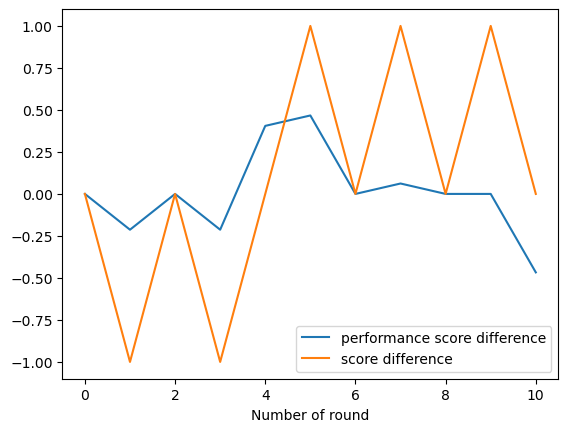

In [131]:
plt.plot(tmp[:11], label='performance score difference')
plt.plot(game[:11], label='score difference')
plt.xlabel('Number of round')
plt.legend()
svg_path = 'picture/Q1delta_set.svg'
plt.savefig(svg_path, format='svg', bbox_inches='tight')
plt.show()

In [90]:
tmp[9]
game[9]

1.0

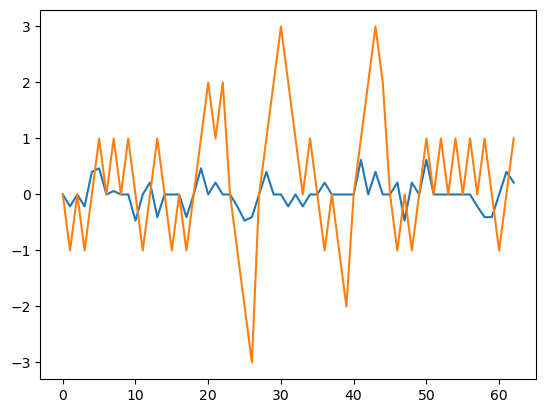

In [78]:
plt.plot(tmp)
plt.plot(game)
plt.show()

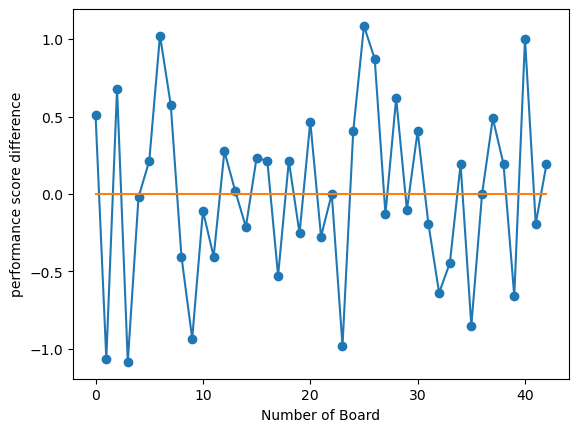

In [134]:
plt.plot(delta, marker='o')
plt.plot([0] * len(delta))
plt.xlabel('Number of Board')
plt.ylabel('performance score difference')
svg_path = 'picture/Q1delta_game.svg'
plt.savefig(svg_path, format='svg', bbox_inches='tight')
plt.show()

In [84]:
delta_performence = np.array(points_won_lists) - np.array(points_won_lists1)
delta_performence

array([  0.387,  -1.209,  -9.895,  -3.411,  -2.585,  11.43 ,  10.497,
         2.519,  -0.055,   2.72 , -11.057,   9.314,   1.949,   8.707,
        -4.347, -11.479,   1.82 ,  -0.729,   3.101,  -2.108,   5.391,
         2.369,  -0.65 ,   4.557,   5.473,   0.718,   6.573,  -4.414,
         1.174,   1.5  ,  13.139])

In [336]:
delta_performence = pd.DataFrame(delta_performence)
delta_performence

,0
0,-0.508
1,1.064
2,-0.680
3,1.085
4,0.021
...,...
1183,-0.213
1184,-0.872
1185,-0.192
1186,-0.062


In [197]:
delta_performence

array([  0.387,  -1.209,  -9.895,  -3.411,  -2.585,  11.43 ,  10.497,
         2.519,  -0.055,   2.72 , -11.057,   9.314,   1.949,   8.707,
        -4.347, -11.479,   1.82 ,  -0.729,   3.101,  -2.108,   5.391,
         2.369,  -0.65 ,   4.557,   5.473,   0.718,   6.573,  -4.414,
         1.174,   1.5  ,  13.139])

In [85]:
player1_is_better = np.where(delta_performence > 0, 1, -1)
player1_is_better

array([ 1, -1, -1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1])

In [80]:
win = wimbledon.groupby('match_id').last()['point_victor']

In [81]:
grouped_data = data.groupby(['match_id'])['index'].sum().values
points_won_lists = np.array(grouped_data).tolist()
points_won_lists

[10.959000000000003,
 9.615000000000006,
 1.2940000000000003,
 10.331000000000001,
 7.113000000000001,
 17.534000000000006,
 22.426000000000002,
 9.374000000000002,
 8.385000000000002,
 7.389000000000004,
 5.956999999999999,
 7.933000000000001,
 11.746000000000004,
 10.898,
 6.518000000000002,
 -0.9449999999999995,
 9.524000000000004,
 12.832000000000006,
 4.887,
 9.938000000000006,
 12.855,
 8.199000000000003,
 17.827,
 20.084999999999997,
 11.654,
 20.026999999999997,
 11.188000000000008,
 8.007000000000003,
 7.157000000000002,
 11.074000000000005,
 17.703000000000003]

In [82]:
grouped_data1 = data1.groupby(['match_id'])[0].sum().values
points_won_lists1 = np.array(grouped_data1).tolist()
points_won_lists1

[10.572000000000001,
 10.824000000000002,
 11.189000000000002,
 13.742000000000003,
 9.698000000000002,
 6.104000000000001,
 11.929,
 6.855,
 8.440000000000001,
 4.669000000000001,
 17.014000000000003,
 -1.3809999999999991,
 9.797,
 2.1910000000000007,
 10.865000000000002,
 10.534,
 7.7040000000000015,
 13.561000000000002,
 1.7860000000000007,
 12.046000000000001,
 7.464000000000001,
 5.830000000000001,
 18.477,
 15.528,
 6.181000000000001,
 19.309,
 4.615000000000001,
 12.421000000000001,
 5.9830000000000005,
 9.574000000000002,
 4.564000000000001]

In [83]:
delta_performence = np.array(points_won_lists) - np.array(points_won_lists1)
delta_performence

array([  0.387,  -1.209,  -9.895,  -3.411,  -2.585,  11.43 ,  10.497,
         2.519,  -0.055,   2.72 , -11.057,   9.314,   1.949,   8.707,
        -4.347, -11.479,   1.82 ,  -0.729,   3.101,  -2.108,   5.391,
         2.369,  -0.65 ,   4.557,   5.473,   0.718,   6.573,  -4.414,
         1.174,   1.5  ,  13.139])

In [150]:
data['new'] = data['index'].sub(data1[0])
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,index,set_no,game_no,new
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1,0.0
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1,-0.213
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1,0.0
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1,-0.213
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1,0.405
...,...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10,-0.213
7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10,0.405
7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10,0.0
7282,0,0,0,0,0,1,2023-wimbledon-1701,0.0,5,10,0.0


In [367]:
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,set_no,game_no,p1_score,new
0,0,0,1,0,0,1,2023-wimbledon-1301,1,1,0.000,0.0
1,0,0,0,0,0,1,2023-wimbledon-1301,1,1,0.000,0.213
2,0,0,1,0,0,1,2023-wimbledon-1301,1,1,0.000,0.0
3,0,1,0,0,0,1,2023-wimbledon-1301,1,1,0.000,0.213
4,1,1,0,0,0,1,2023-wimbledon-1301,1,1,0.000,-0.405
...,...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701,5,10,0.000,0.213
7280,0,1,0,0,1,1,2023-wimbledon-1701,5,10,0.000,-0.405
7281,0,0,0,0,0,1,2023-wimbledon-1701,5,10,0.405,0.0
7282,0,0,0,0,0,1,2023-wimbledon-1701,5,10,0.000,0.0


In [368]:
data1

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id,index,set_no,game_no
0,0,0,0,0,0,0,2023-wimbledon-1301,0.0,1,1
1,0,0,0,0,0,0,2023-wimbledon-1301,-0.213,1,1
2,0,0,0,0,0,0,2023-wimbledon-1301,0.0,1,1
3,0,0,0,0,0,0,2023-wimbledon-1301,-0.213,1,1
4,0,0,0,0,0,0,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...
7279,0,0,0,0,0,0,2023-wimbledon-1701,-0.213,5,10
7280,0,0,0,0,0,0,2023-wimbledon-1701,0.405,5,10
7281,0,1,0,0,0,0,2023-wimbledon-1701,0.405,5,10
7282,0,0,0,0,0,0,2023-wimbledon-1701,0.0,5,10


In [151]:
grouped_data2 = data.groupby(['match_id'])['new'].sum().values
delta_performence = np.array(grouped_data).tolist()
delta_performence

[10.959000000000003,
 9.615000000000006,
 1.2940000000000003,
 10.331000000000001,
 7.113000000000001,
 17.534000000000006,
 22.426000000000002,
 9.374000000000002,
 8.385000000000002,
 7.389000000000004,
 5.956999999999999,
 7.933000000000001,
 11.746000000000004,
 10.898,
 6.518000000000002,
 -0.9449999999999995,
 9.524000000000004,
 12.832000000000006,
 4.887,
 9.938000000000006,
 12.855,
 8.199000000000003,
 17.827,
 20.084999999999997,
 11.654,
 20.026999999999997,
 11.188000000000008,
 8.007000000000003,
 7.157000000000002,
 11.074000000000005,
 17.703000000000003]

In [152]:
player1_is_better = np.where(np.array(delta_performence) > 0, 1, -1)
player1_is_better

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [183]:
win

match_id
2023-wimbledon-1301    1
2023-wimbledon-1302    2
2023-wimbledon-1303    2
2023-wimbledon-1304    2
2023-wimbledon-1305    1
2023-wimbledon-1306    1
2023-wimbledon-1307    1
2023-wimbledon-1308    2
2023-wimbledon-1309    1
2023-wimbledon-1310    1
2023-wimbledon-1311    2
2023-wimbledon-1312    1
2023-wimbledon-1313    1
2023-wimbledon-1314    1
2023-wimbledon-1315    2
2023-wimbledon-1316    2
2023-wimbledon-1401    1
2023-wimbledon-1402    2
2023-wimbledon-1403    1
2023-wimbledon-1404    1
2023-wimbledon-1405    1
2023-wimbledon-1406    1
2023-wimbledon-1407    1
2023-wimbledon-1408    2
2023-wimbledon-1501    1
2023-wimbledon-1502    1
2023-wimbledon-1503    1
2023-wimbledon-1504    2
2023-wimbledon-1601    1
2023-wimbledon-1602    2
2023-wimbledon-1701    1
Name: point_victor, dtype: int64

In [154]:
# win = win.replace(0, -1)
# win

In [91]:
player1_is_better

array([ 1, -1, -1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1])

In [92]:
win

match_id
2023-wimbledon-1301    1
2023-wimbledon-1302    2
2023-wimbledon-1303    2
2023-wimbledon-1304    2
2023-wimbledon-1305    1
2023-wimbledon-1306    1
2023-wimbledon-1307    1
2023-wimbledon-1308    2
2023-wimbledon-1309    1
2023-wimbledon-1310    1
2023-wimbledon-1311    2
2023-wimbledon-1312    1
2023-wimbledon-1313    1
2023-wimbledon-1314    1
2023-wimbledon-1315    2
2023-wimbledon-1316    2
2023-wimbledon-1401    1
2023-wimbledon-1402    2
2023-wimbledon-1403    1
2023-wimbledon-1404    1
2023-wimbledon-1405    1
2023-wimbledon-1406    1
2023-wimbledon-1407    1
2023-wimbledon-1408    2
2023-wimbledon-1501    1
2023-wimbledon-1502    1
2023-wimbledon-1503    1
2023-wimbledon-1504    2
2023-wimbledon-1601    1
2023-wimbledon-1602    2
2023-wimbledon-1701    1
Name: point_victor, dtype: int64

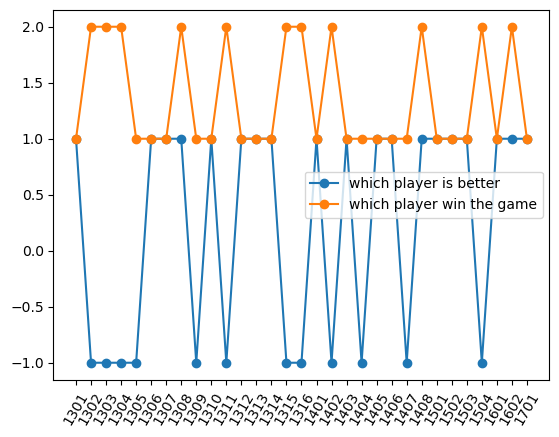

In [132]:
xlabel = ['1301', '1302', '1303', '1304', '1305', '1306', '1307', '1308', '1309', '1310', '1311', '1312', '1313', '1314', '1315', '1316', 
            '1401', '1402', '1403', '1404', '1405', '1406', '1407', '1408', '1501', '1502', '1503', '1504','1601', '1602', '1701']

plt.plot(player1_is_better, marker='o', label = 'which player is better')
plt.plot(win, marker='o', label = 'which player win the game')
plt.legend()
plt.xticks(win.index, xlabel, rotation=60)
svg_path = 'picture/Q1compare_performance.svg'
plt.savefig(svg_path, format='svg', bbox_inches='tight')
plt.show()

In [92]:
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,index,set_no,game_no
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10
7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10
7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10
7282,0,0,0,0,0,1,2023-wimbledon-1701,0.0,5,10


In [112]:
turnpoint = wimbledon['p1_score'] - wimbledon['p2_score']
turnpoint = turnpoint.fillna(0)
turnpoint
wimbledon['p1_score'].unique()

array([ 0, 15, 30, 40, 50,  1,  2,  3,  4,  5,  6,  7,  8,  9],
      dtype=int64)

In [104]:
p1 = data['index'] - data1[0]
p1

0         0.0
1      -0.213
2         0.0
3      -0.213
4       0.405
        ...  
7279   -0.213
7280    0.405
7281      0.0
7282      0.0
7283      0.0
Length: 7284, dtype: object

In [105]:
import numpy as np
from scipy.stats import pearsonr

# 计算皮尔逊相关系数和P值
correlation, p_value = pearsonr(np.array(p1), np.array(turnpoint))

print(f'Pearson correlation coefficient: {correlation}')
print(f'P-value: {p_value:.4f}')


Pearson correlation coefficient: 0.26652026634417364
P-value: 0.0000


In [106]:
from scipy.stats import spearmanr
correlation, p_value = spearmanr(np.array(p1), np.array(turnpoint))

print(f'Pearson correlation coefficient: {correlation}')
print(f'P-value: {p_value:.4f}')


Pearson correlation coefficient: 0.2680543849480887
P-value: 0.0000


In [113]:
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,index,set_no,game_no
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10
7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10
7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10
7282,0,0,0,0,0,1,2023-wimbledon-1701,0.0,5,10


In [114]:
data = data.rename(columns={'index': 'p1_score'})
data

,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,p1_score,set_no,game_no
0,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
2,0,0,1,0,0,1,2023-wimbledon-1301,0.0,1,1
3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...
7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10
7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10
7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10
7282,0,0,0,0,0,1,2023-wimbledon-1701,0.0,5,10


In [115]:
data1 = data1.rename(columns={0: 'p2_score'})
data1

,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id,p2_score,set_no,game_no
0,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
1,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
2,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
3,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
4,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
...,...,...,...,...,...,...,...,...,...,...
7279,0,0,0,0,0,0,2023-wimbledon-1701,0.000,5,10
7280,0,0,0,0,0,0,2023-wimbledon-1701,0.000,5,10
7281,0,1,0,0,0,0,2023-wimbledon-1701,0.405,5,10
7282,0,0,0,0,0,0,2023-wimbledon-1701,0.000,5,10


In [116]:
data.to_csv('p1_score.csv')

In [117]:
data1.to_csv('p2_score.csv')

In [134]:
df

0         0.0
0      -0.213
1         0.0
2      -0.213
3       0.405
        ...  
7278   -0.213
7279    0.405
7280    0.405
7281      0.0
7282      0.0
Name: index, Length: 7284, dtype: object

In [135]:
df1

0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
        ...  
7279    0.000
7280    0.000
7281    0.405
7282    0.000
7283    0.000
Length: 7284, dtype: float64

Original Pearson Correlation: -0.5960620307214
P-value: 0.0001


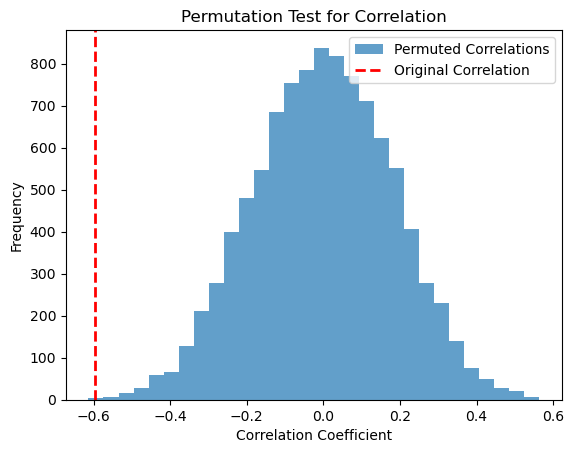

In [135]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# 生成假设的两组数据
data_x = delta_performence
data_y = win

# 计算原始数据的皮尔逊相关系数
original_corr, _ = pearsonr(data_x, data_y)

# 置换测试
n_permutations = 10000  # 置换次数
perm_corrs = []  # 存储每次置换得到的相关系数
for _ in range(n_permutations):
    permuted_y = np.random.permutation(data_y)  # 随机打乱第二组数据
    perm_corr, _ = pearsonr(data_x, permuted_y)  # 计算当前置换的相关系数
    perm_corrs.append(perm_corr)

# 计算p值
p_value = np.sum(np.abs(perm_corrs) >= np.abs(original_corr)) / n_permutations

# 输出原始相关系数和p值
print(f"Original Pearson Correlation: {original_corr}")
print(f"P-value: {p_value}")

# 绘制置换测试得到的相关系数分布的直方图
plt.hist(perm_corrs, bins=30, alpha=0.7, label='Permuted Correlations')
plt.axvline(x=original_corr, color='r', linestyle='dashed', linewidth=2, label='Original Correlation')
plt.title('Permutation Test for Correlation')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.legend()
svg_path = 'picture/Q2Permulation Test for Correlation.svg'
plt.savefig(svg_path, format='svg', bbox_inches='tight')
plt.show()